In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import bbknn
import scvelo as scv
import anndata
import leidenalg
import loompy
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import rc_context
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import random

C:\Users\tpsa222\.conda\envs\young\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\tpsa222\.conda\envs\young\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\tpsa222\.conda\envs\young\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [2]:
sc.set_figure_params(format='png')  # for beautified visualization
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params(style='scvelo', format='png')  # for beautified visualization
# Set working directory
os.chdir("Y:/Tolulope/Cellranger Results/transyoung")

Sham_GFP = 'Y:/Tolulope/Cellranger Results/transyoung/Sham_GFP/filtered_feature_bc_matrix'
Sham_noGFP = 'Y:/Tolulope/Cellranger Results/transyoung/Sham_noGFP/filtered_feature_bc_matrix'
OV_GFP = 'Y:/Tolulope/Cellranger Results/transyoung/OV_GFP/filtered_feature_bc_matrix'
OV_noGFP = 'Y:/Tolulope/Cellranger Results/transyoung/OV_noGFP/filtered_feature_bc_matrix'


# Read the 10x Genomics data into an AnnData object
adata1 = sc.read_10x_mtx(
    Sham_GFP,                 # Path to the directory with the `.mtx` file
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True                 # Write a cache file for faster subsequent reading
)

# Read the 10x Genomics data into an AnnData object
adata2 = sc.read_10x_mtx(
    Sham_noGFP,                 # Path to the directory with the `.mtx` file
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True                 # Write a cache file for faster subsequent reading
)
# Read the 10x Genomics data into an AnnData object
adata3 = sc.read_10x_mtx(
    OV_GFP,                 # Path to the directory with the `.mtx` file
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True                 # Write a cache file for faster subsequent reading
)
# Read the 10x Genomics data into an AnnData object
adata4 = sc.read_10x_mtx(
    OV_noGFP,                 # Path to the directory with the `.mtx` file
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True                 # Write a cache file for faster subsequent reading
)

# Now `adata1,2,3,4` contains your 10x Genomics data in an AnnData object


adata1.var_names_make_unique()    # unnecessary if `var_names='gene_ids'`
adata2.var_names_make_unique() 
adata3.var_names_make_unique() 
adata4.var_names_make_unique() 

adata1.raw = adata1
adata2.raw = adata2
adata3.raw = adata3
adata4.raw = adata4

In [3]:
adata = adata1.concatenate([adata2,adata3,adata4], batch_categories=['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP'])

In [4]:
adata.X.shape

(24632, 33768)

In [5]:
adata.obs['Sample'] = adata.obs['batch']
adata.obs.drop('batch', axis=1, inplace=True)

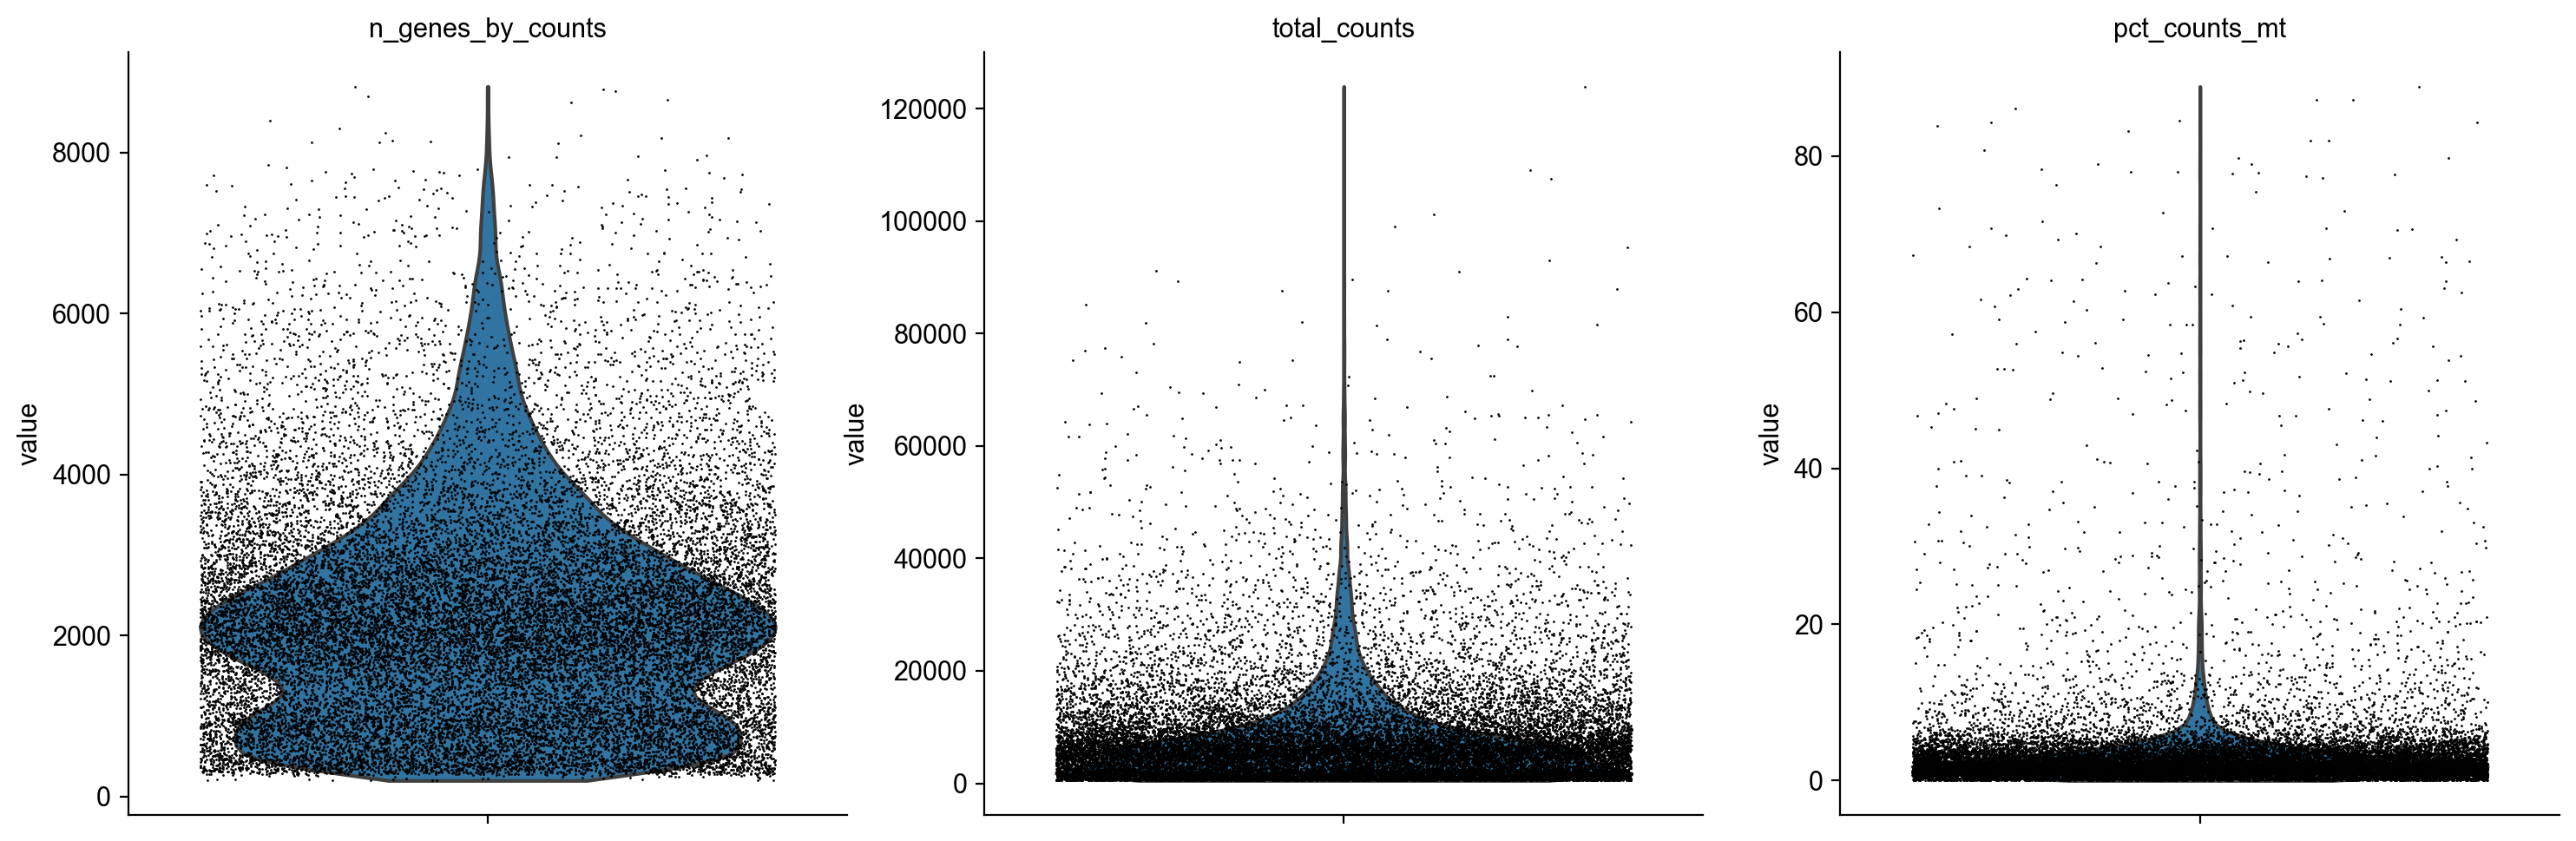

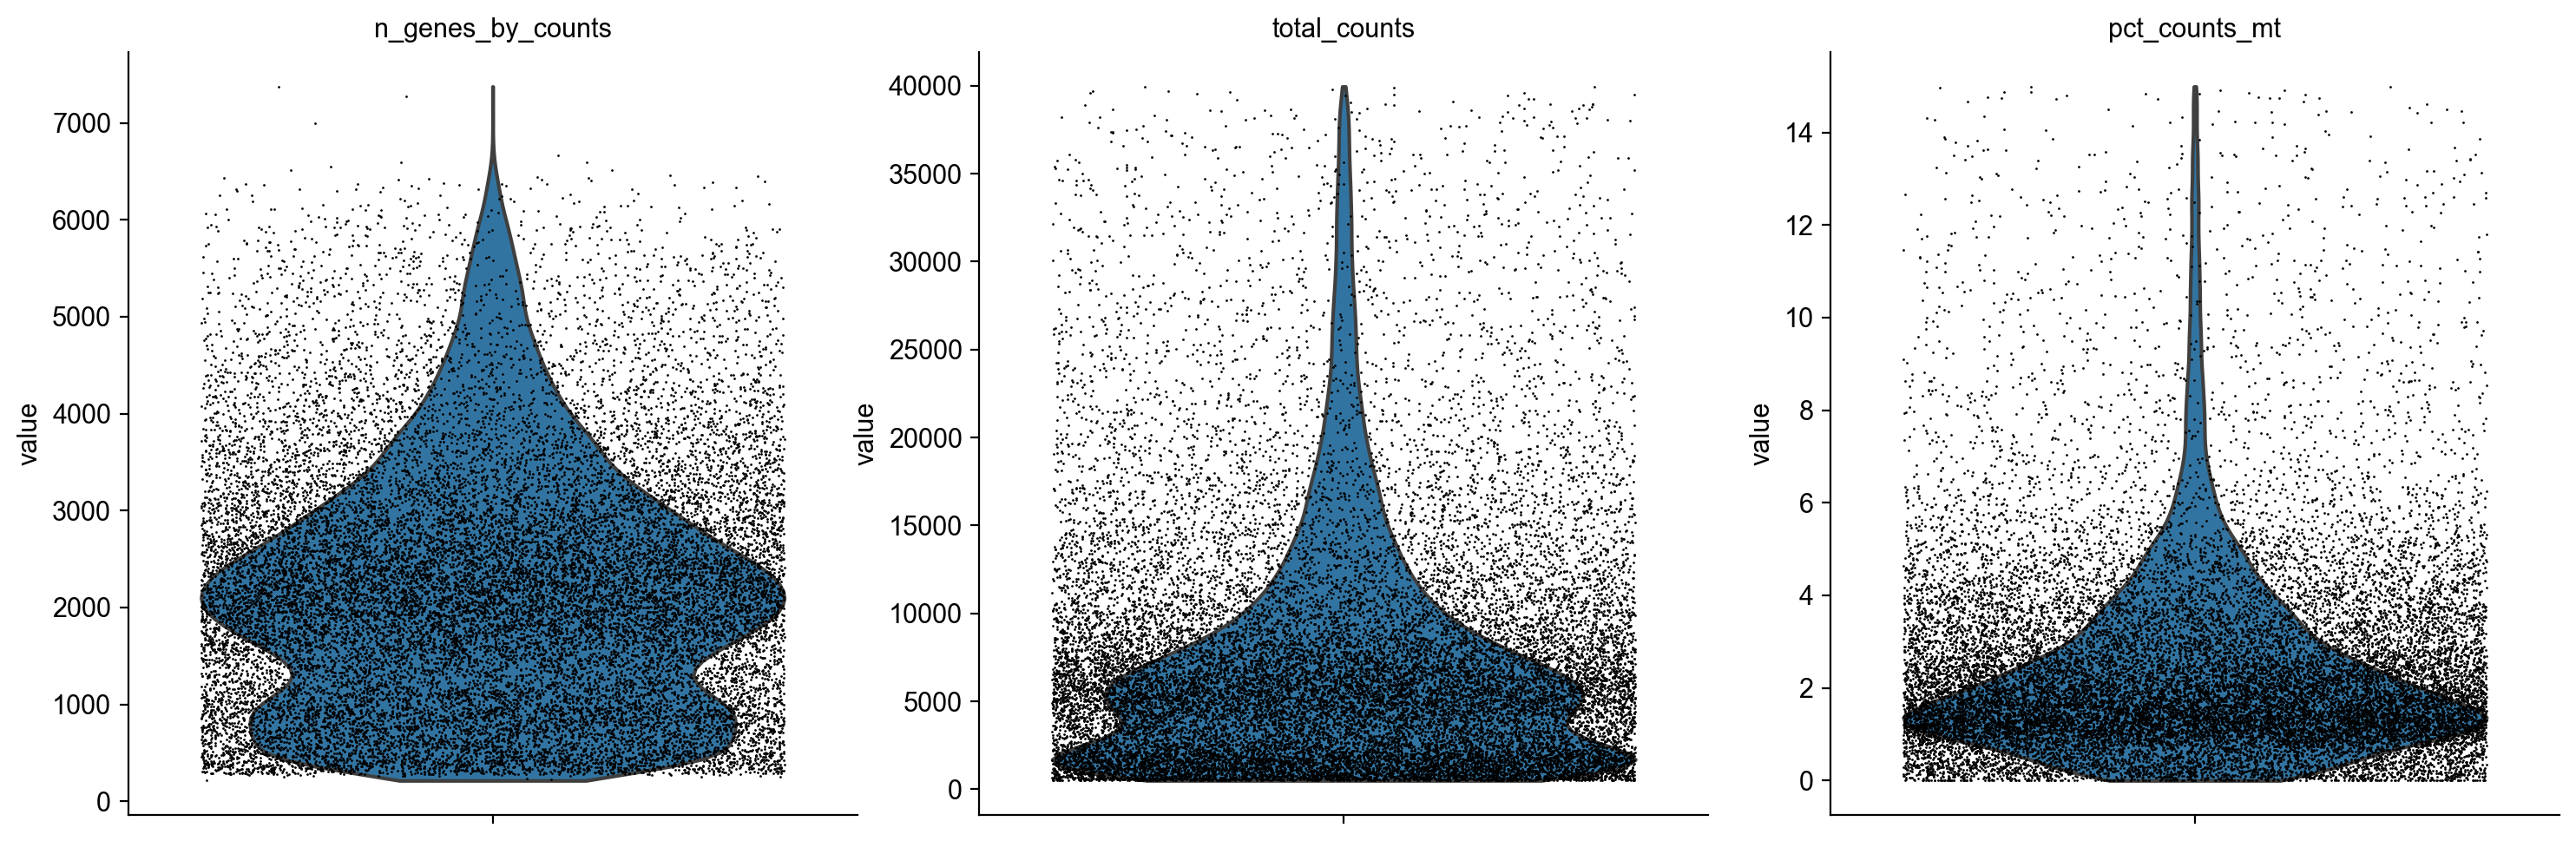

In [6]:
# filter
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

adata.var['mt']= adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, save='violin_plot.png')

adata=adata[adata.obs.n_genes_by_counts < 8000, :]
adata=adata[adata.obs.total_counts < 40000, :]
adata=adata[adata.obs.pct_counts_mt < 15, :]

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, save='violin_plot.png')

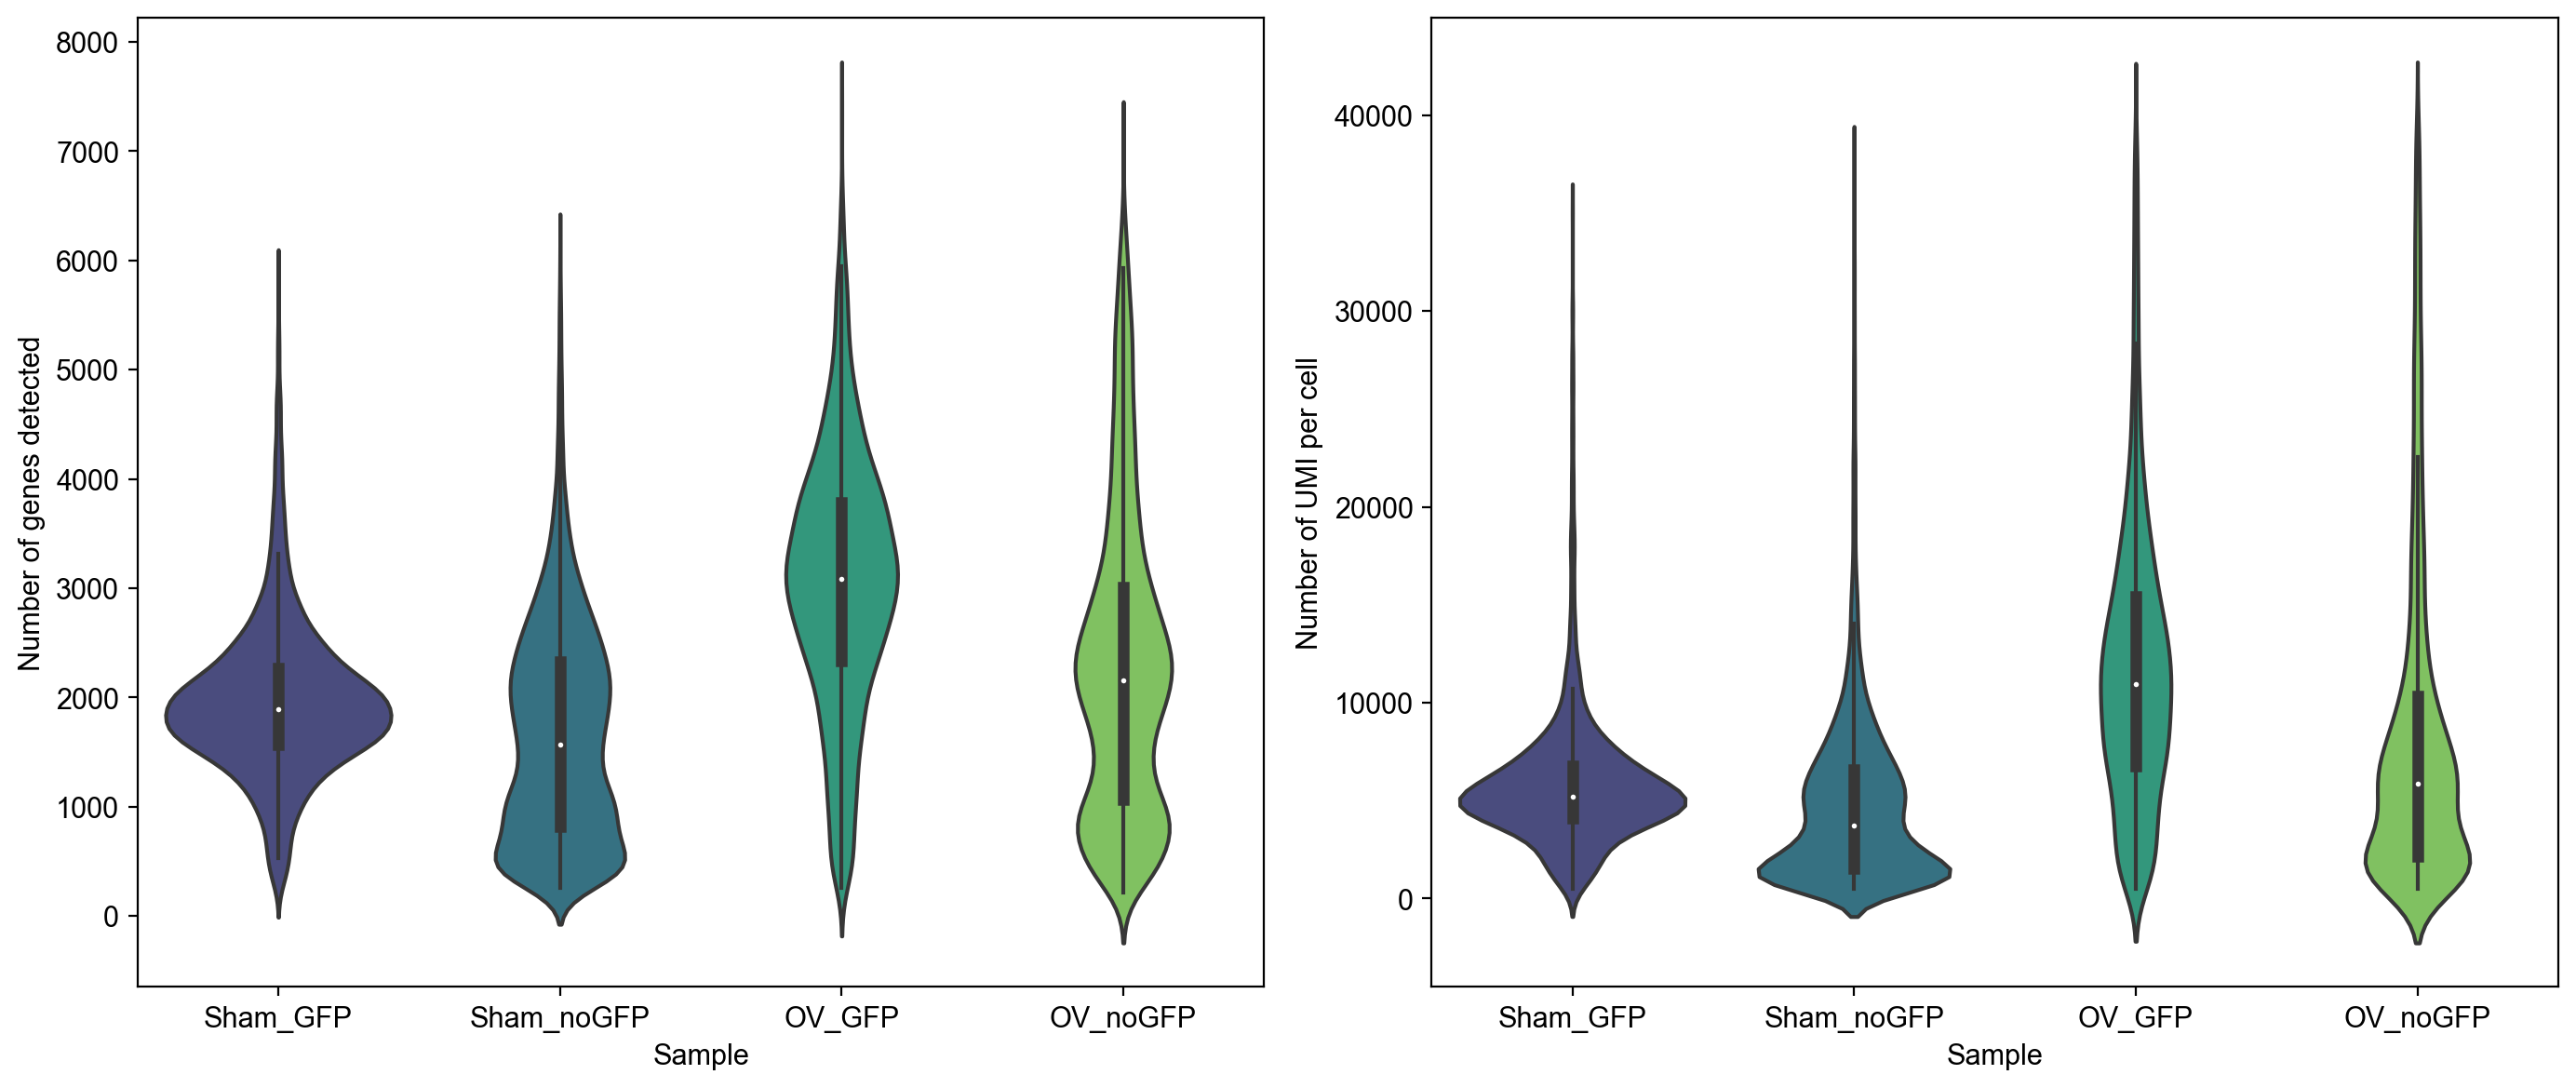

In [7]:
pl.figure(figsize=(14, 6))

# Violin plot for n_genes_by_counts
pl.subplot(1, 2, 1)
sns.violinplot(x='Sample', y='n_genes', data=adata.obs, palette='viridis')

# Label the axes
pl.xlabel('Sample')
pl.ylabel('Number of genes detected')


adata.obs['total_counts']=adata.X.sum(axis=1)
pl.subplot(1, 2, 2)
#sns.stripplot(x='batch', y=adata5.X.sum(axis=1).A1, data=adata.obs, palette='viridis', jitter=True)
sns.violinplot(x='Sample', y='total_counts', data=adata.obs, palette='viridis')

# Label the axes
pl.xlabel('Sample')
pl.ylabel('Number of UMI per cell')



pl.tight_layout()

# Save the plot
pl.savefig('violin_plot.png')  # You can specify a different file format (e.g., .pdf, .svg) if needed
pl.show()

In [8]:
adata.X

<23528x24401 sparse matrix of type '<class 'numpy.float32'>'
	with 51374623 stored elements in Compressed Sparse Row format>

In [9]:
from scipy.sparse import csr_matrix

In [10]:
adata.X = csr_matrix(adata.X)

In [11]:
adata.X

<23528x24401 sparse matrix of type '<class 'numpy.float32'>'
	with 51374623 stored elements in Compressed Sparse Row format>

In [12]:
adata.obs.groupby('Sample').count()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
Sample                                                                  
Sham_GFP       2659               2659          2659             2659   
Sham_noGFP     7950               7950          7950             7950   
OV_GFP         4593               4593          4593             4593   
OV_noGFP       8326               8326          8326             8326   

            pct_counts_mt  
Sample                     
Sham_GFP             2659  
Sham_noGFP           7950  
OV_GFP               4593  
OV_noGFP             8326

In [13]:
adata.layers['counts'] = adata.X.copy()

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [15]:
adata.X.sum(axis = 1)

matrix([[10000.   ],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [16]:
sc.pp.log1p(adata) #change to log counts

In [17]:
adata.X.sum(axis = 1)

matrix([[3810.1868],
        [3053.7664],
        [2852.1592],
        ...,
        [3180.5278],
        [2592.2397],
        [3259.6328]], dtype=float32)

In [18]:
adata.raw = adata

In [19]:
adata.obs.head()

Sample  n_genes  n_genes_by_counts  \
AAACCCAGTTCCGTTC-1-Sham_GFP  Sham_GFP     3572               3572   
AAACCCATCCATACTT-1-Sham_GFP  Sham_GFP     2373               2373   
AAACCCATCCCACAGG-1-Sham_GFP  Sham_GFP     2003               2003   
AAACGAACATACCACA-1-Sham_GFP  Sham_GFP     2215               2215   
AAACGAAGTCGTGGTC-1-Sham_GFP  Sham_GFP     2247               2247   

                             total_counts  total_counts_mt  pct_counts_mt  
AAACCCAGTTCCGTTC-1-Sham_GFP       11059.0            432.0       3.906321  
AAACCCATCCATACTT-1-Sham_GFP        7142.0            280.0       3.920470  
AAACCCATCCCACAGG-1-Sham_GFP        5501.0            139.0       2.526813  
AAACGAACATACCACA-1-Sham_GFP        6809.0            175.0       2.570128  
AAACGAAGTCGTGGTC-1-Sham_GFP        6941.0            388.0       5.589973

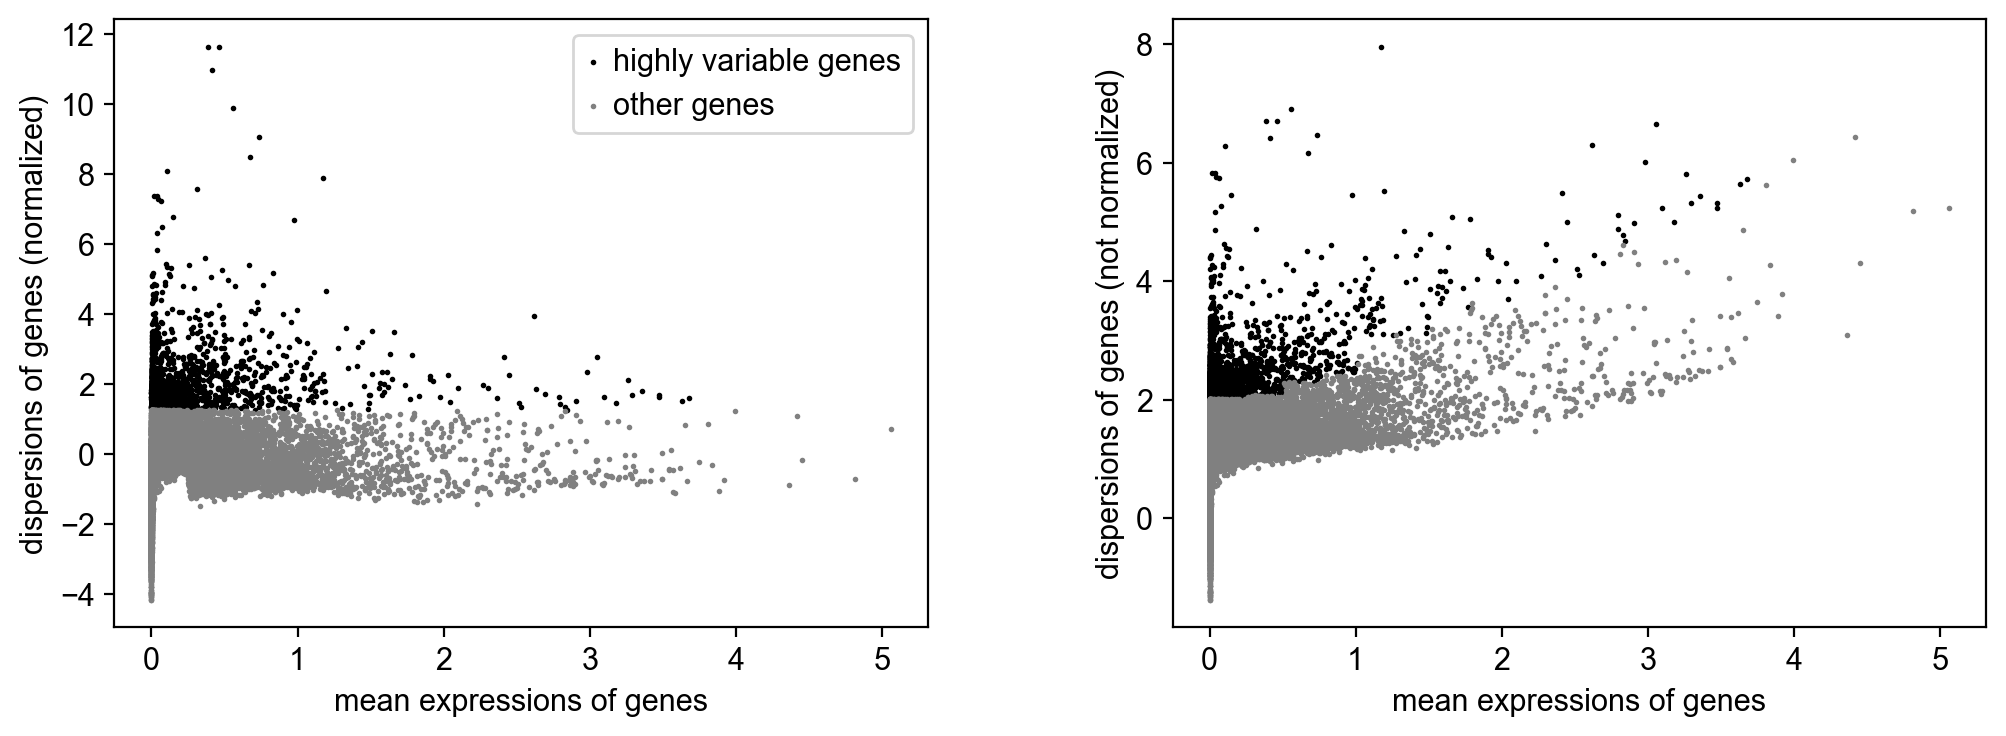

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_bins=20,  n_top_genes=2000)

projID = "vaiable genes_1"  # Define projID with a specific value, such as a string representing your project ID
n1 = 1  # Define n1 with a specific numerical value

sc.pl.highly_variable_genes(adata, save=f"{projID}_high_variable_{n1}.png")

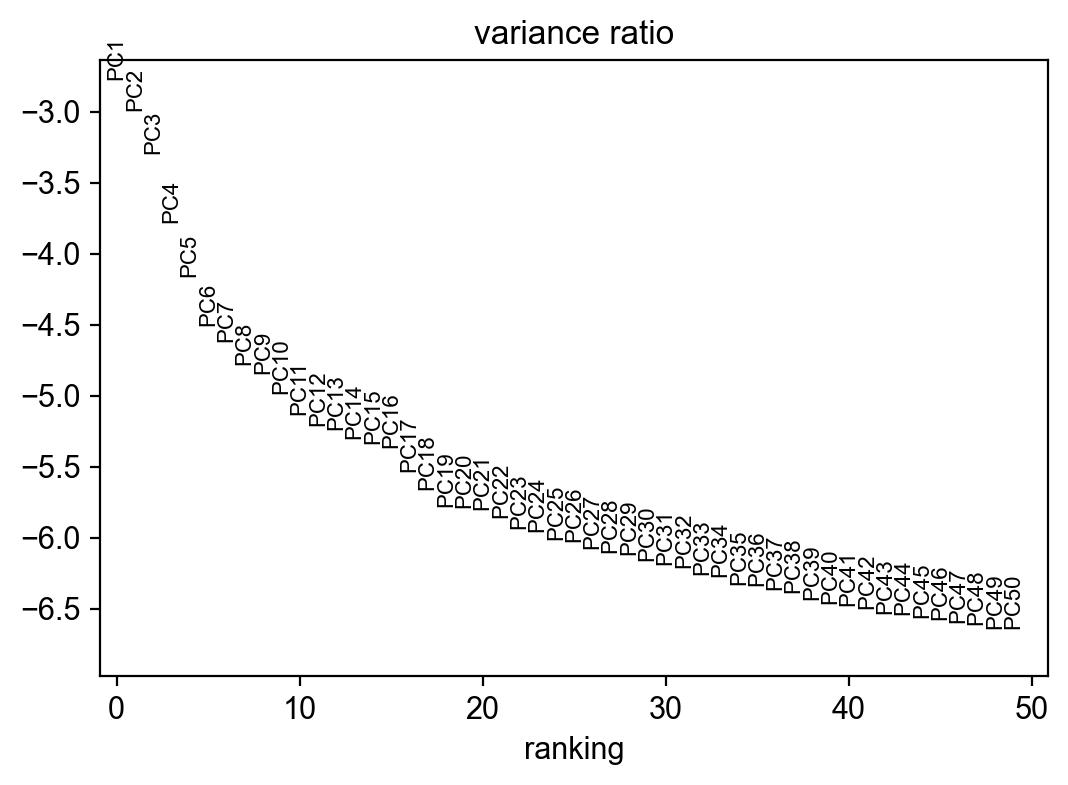

In [21]:
sc.pp.scale(adata, max_value=10) 
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

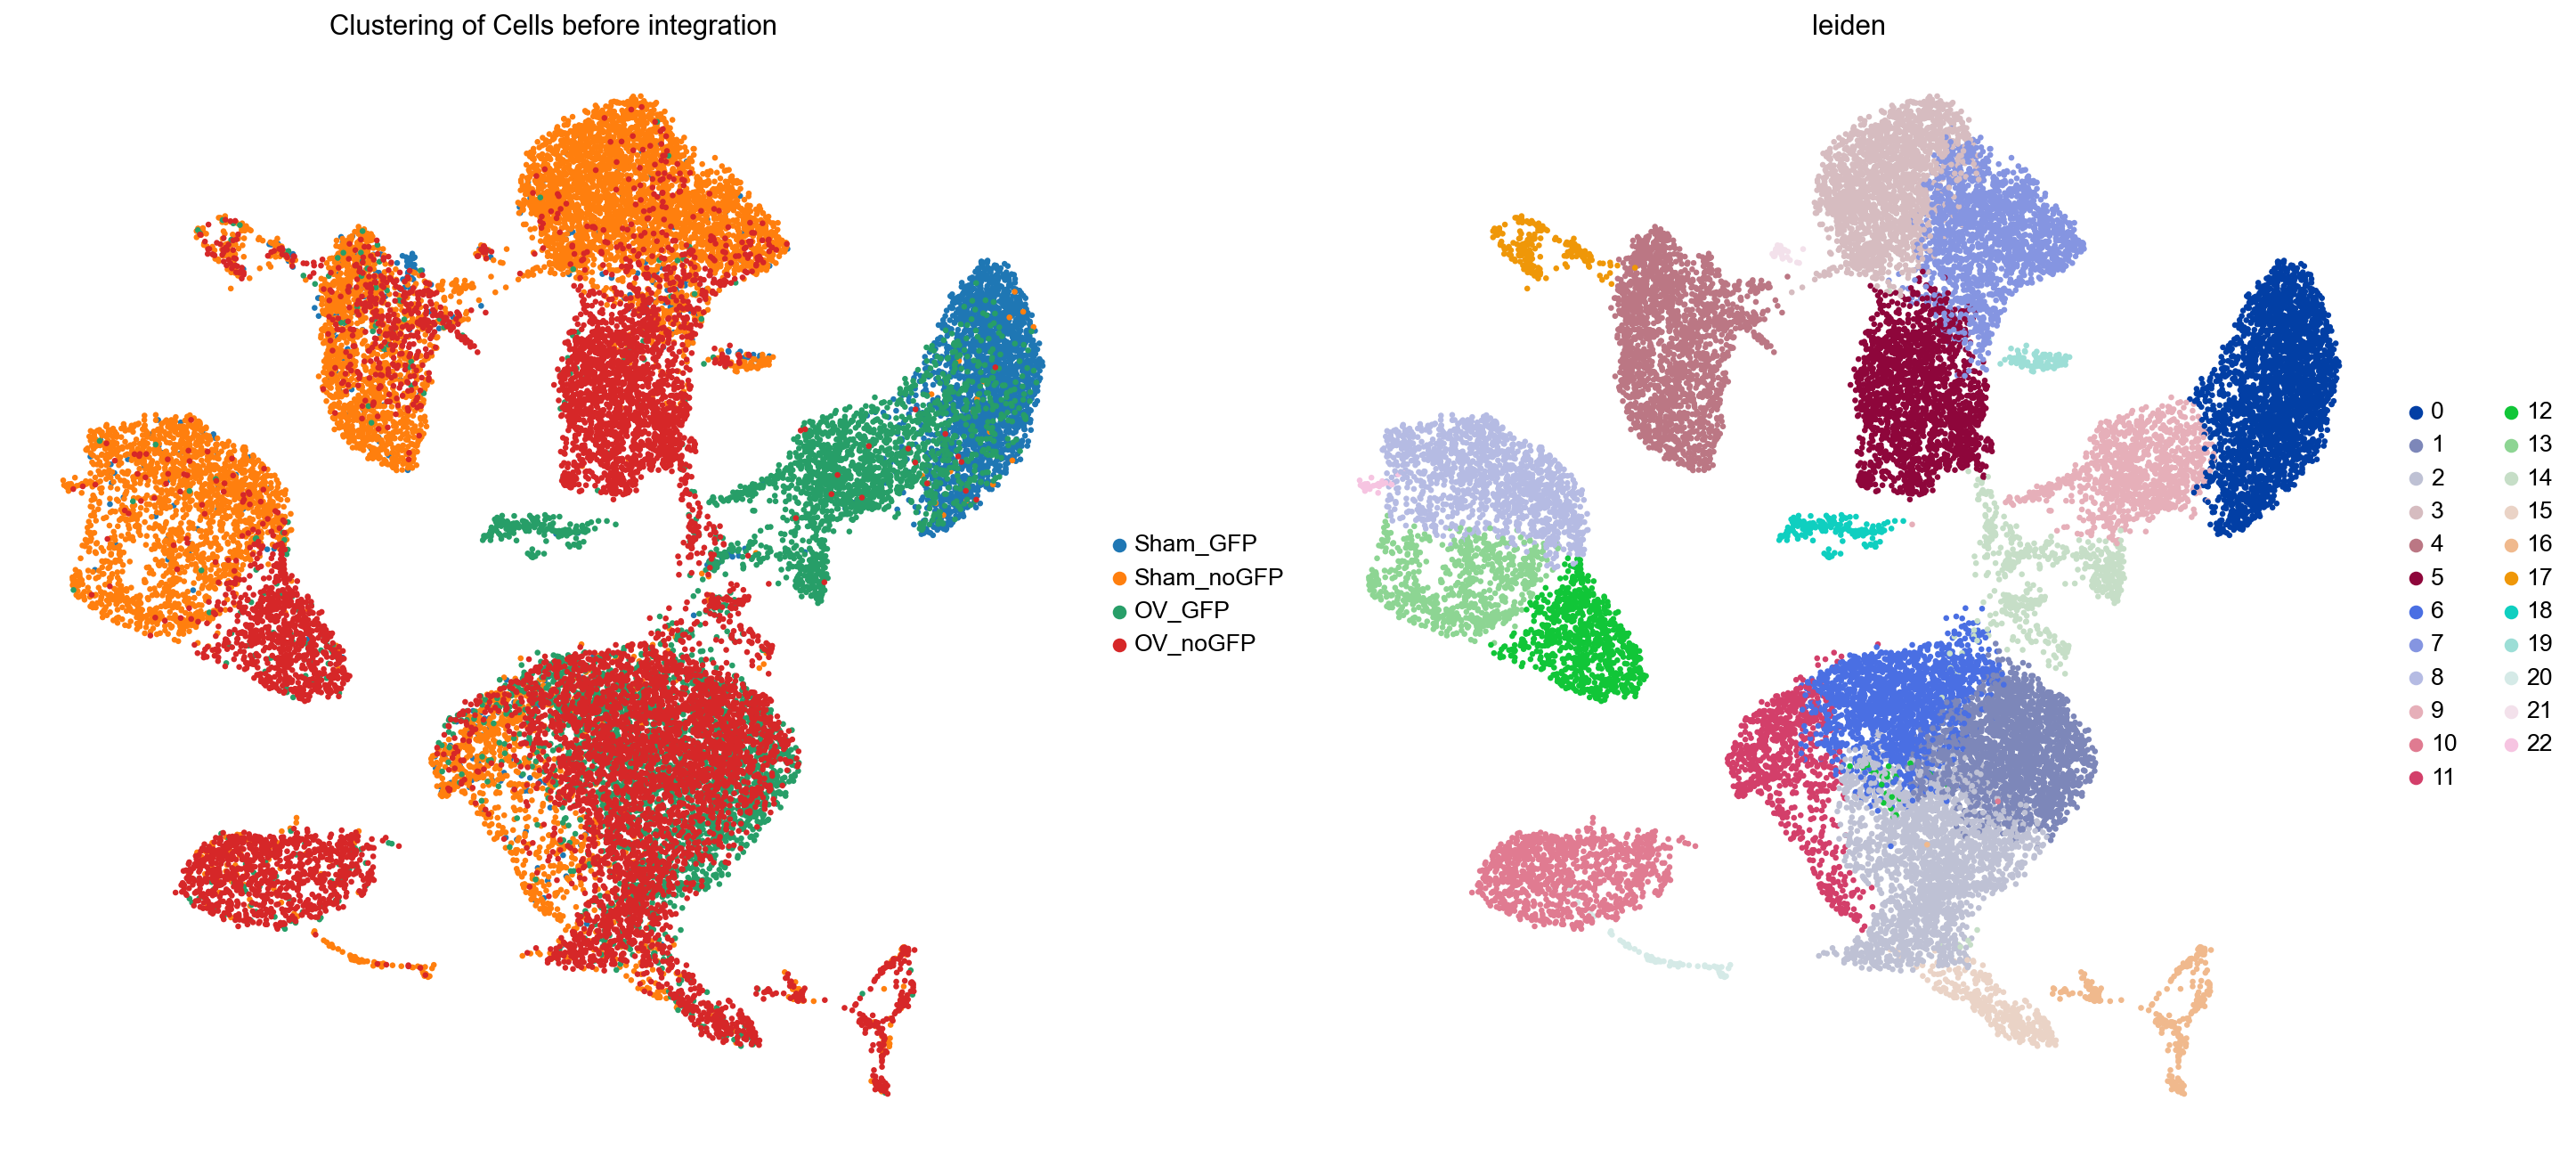

In [22]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['Sample', 'leiden'], legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells before integration', save=f'umap_plot{img_tag}.png')

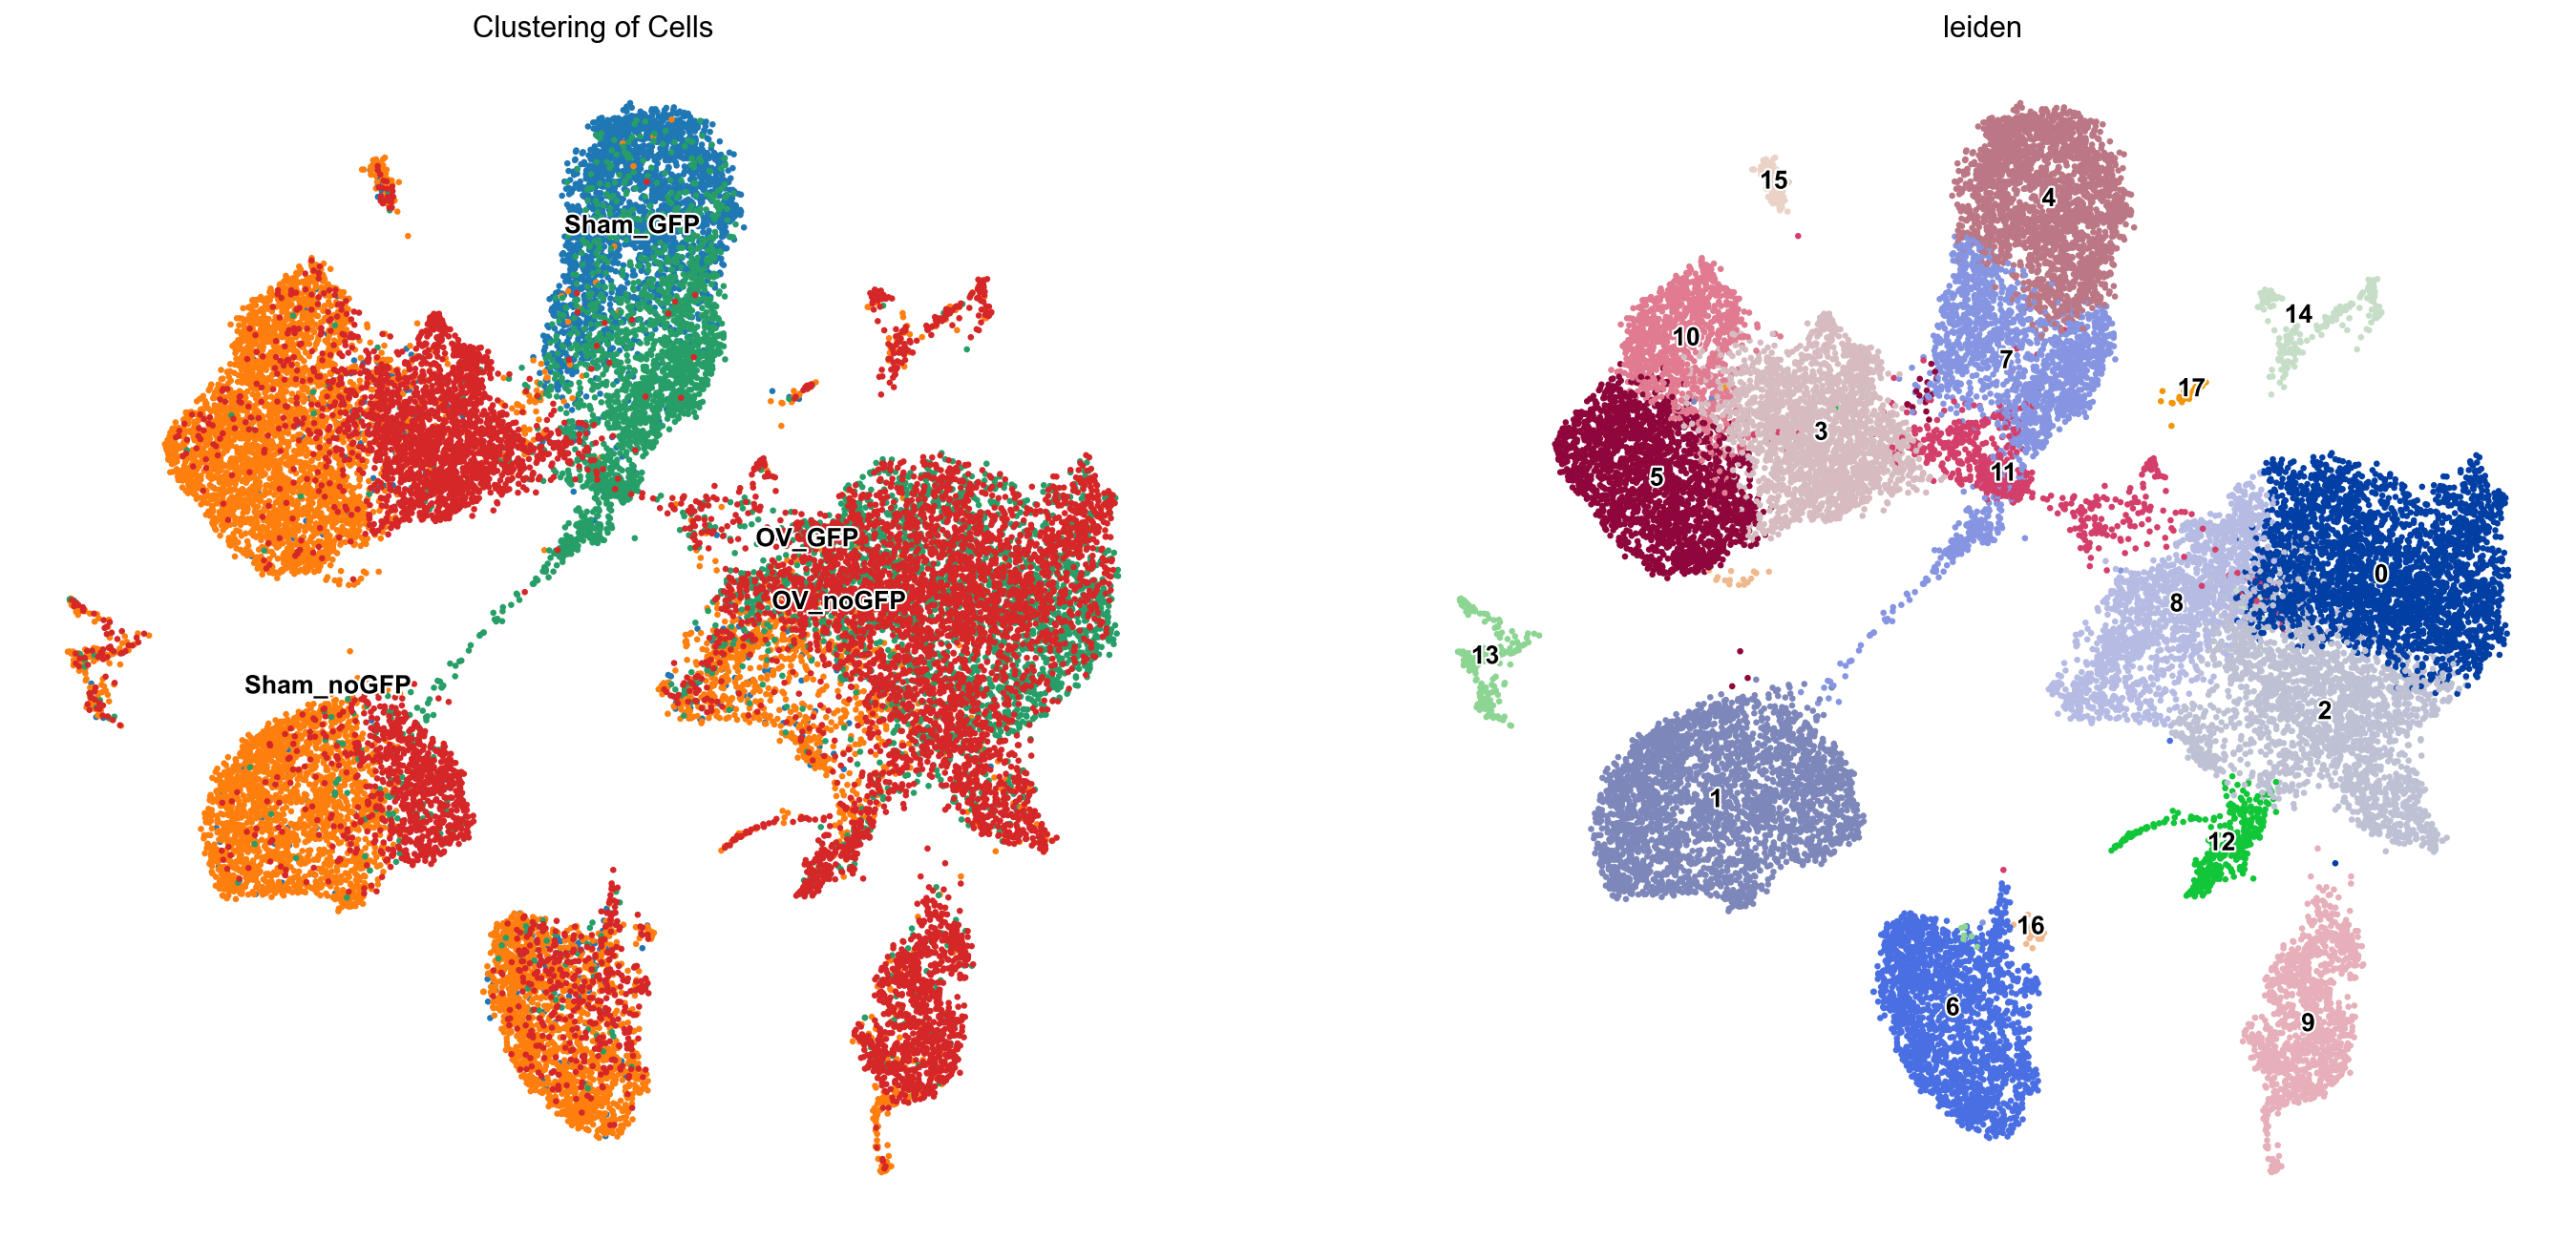

In [23]:
#BBKNN
sc.external.pp.bbknn(adata, batch_key="Sample")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['Sample', 'leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot{img_tag}.png')
pl.show()

In [24]:
#RedsModified = cm.get_cmap('Reds', 12)
#RedsModified = cm.get_cmap('Reds', 256)
#newcolors = RedsModified(np.linspace(0, 1, 256))
#grey = np.array([220/256, 220/256, 220/256, 1])

# Modify this val to change the 
# area that will be grey on the cmap
#lim = 10
#newcolors[:lim, :] = grey
#newcmp = ListedColormap(newcolors)

In [24]:
# Find markers/ label cell types

In [25]:
cell_type = {
    "0": "Monocytes/macrophages/Platelet",
    "1": "Mature skeletal muscle",
    "2": "Residence Macrophages/APC 1",
    "3": "Myo-Fibroblast",
    "4": "MuSCs and Myoblasts",
    "5": "Fibroblast 1",
    "6": "Endothelial cells 1",
    "7": "MuSCs and myogenic progenitor cells",
    "8": "Anti-inflammatory Macrophages",
    "9": "Neutrophils",
    "10": "Fibroblast 2",
    "11": "Unclassified",
    "12": "Residence Macrophages/APC 2",
    "13": "Pericyte cells",
    "14": "T-lymphocytes and Natural killer cells",
    "15": "Tenocyte",
    "16": "Endothelial cells 2",
    "17": "Schwann cells",
   
}

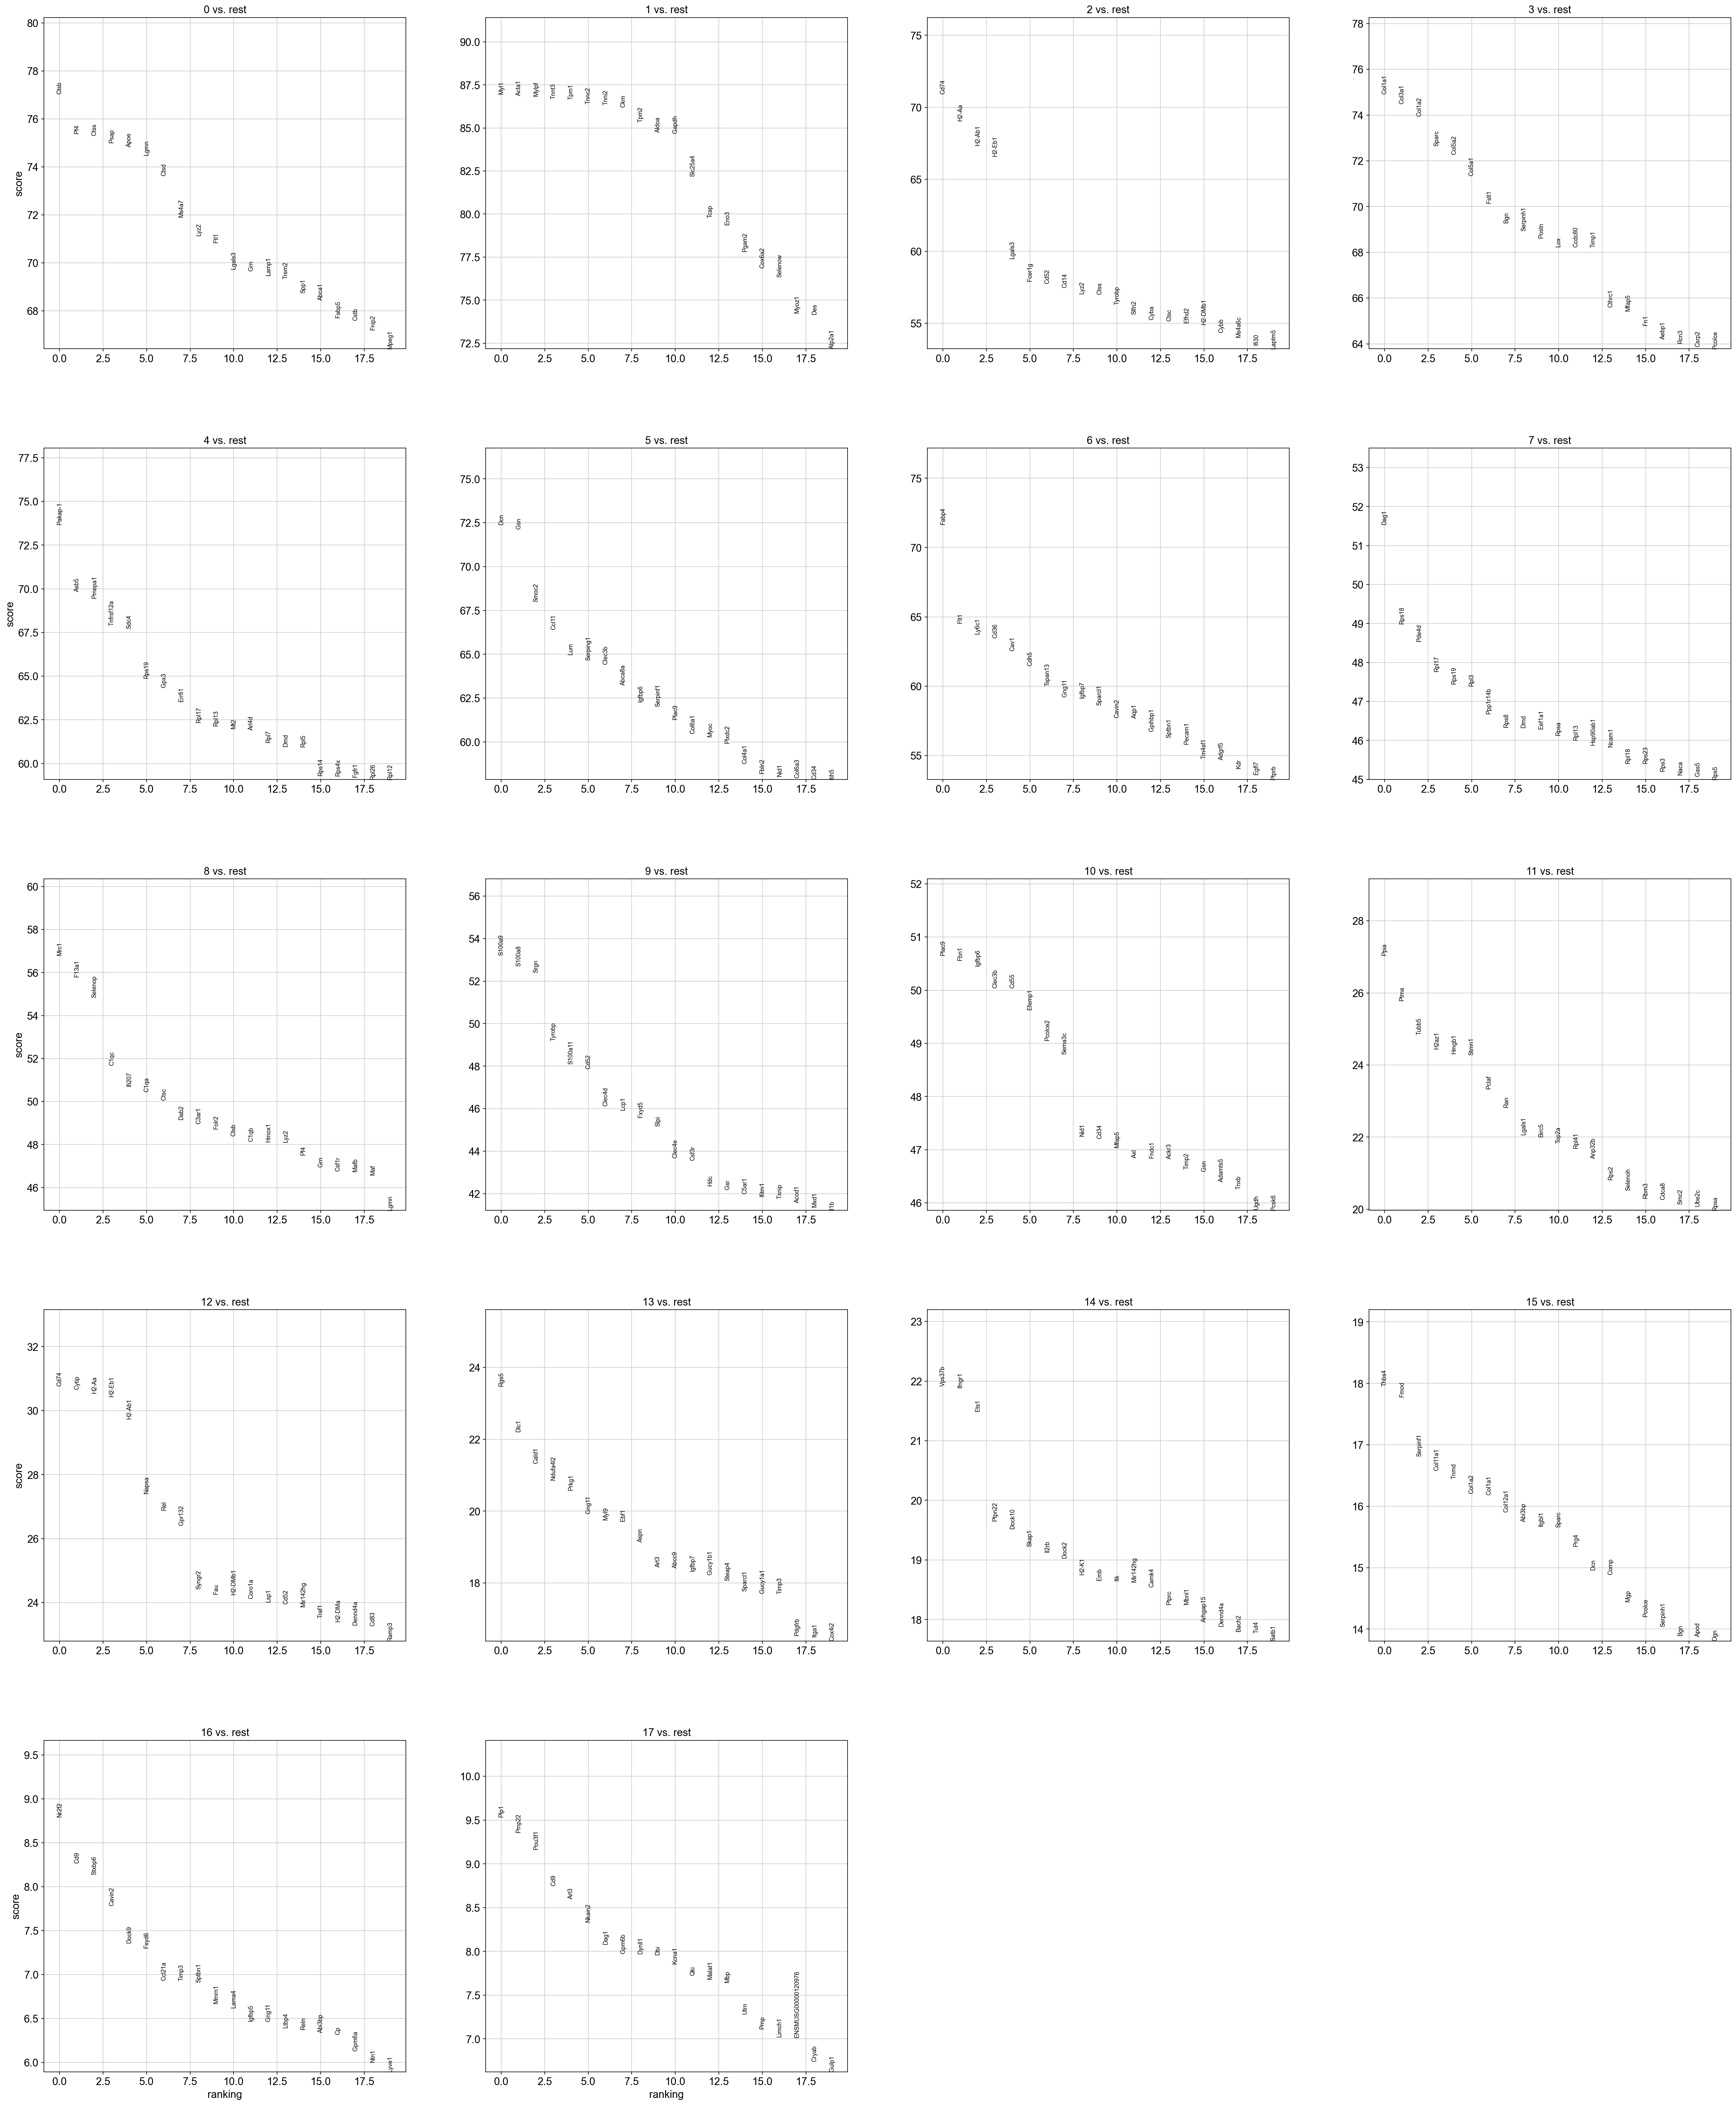

In [33]:
# Find markers/ label cell types

#sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [35]:
#markers = sc.get.rank_genes_groups_df(adata, None)
#markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
#markers


group    names     scores  logfoldchanges     pvals  pvals_adj
0          0     Ctsb  77.040245        3.555306  0.000000   0.000000
1          0      Pf4  75.384575        5.061861  0.000000   0.000000
2          0     Ctss  75.298805        4.713539  0.000000   0.000000
3          0     Psap  75.001244        3.216640  0.000000   0.000000
4          0     Apoe  74.819977        4.833651  0.000000   0.000000
...      ...      ...        ...             ...       ...        ...
414993    17  Ldlrad3   3.470478        3.386450  0.000520   0.044638
414994    17  Col20a1   3.468578        6.055809  0.000523   0.044797
414995    17  Selenom   3.458192        1.491602  0.000544   0.045857
414996    17    Cadm2   3.456411        5.508847  0.000547   0.045857
414997    17    Klf13   3.455754        1.426942  0.000549   0.045857

[33933 rows x 6 columns]

In [36]:
# markers[markers.names =='Myl9']

group names     scores  logfoldchanges          pvals      pvals_adj
74338      3  Myl9  24.255484        2.762310  5.787545e-130  1.234457e-128
317219    13  Myl9  19.755032        6.516038   7.260931e-87   2.531057e-83
366734    15  Myl9   3.570646        1.737596   3.561018e-04   8.689241e-03

In [26]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

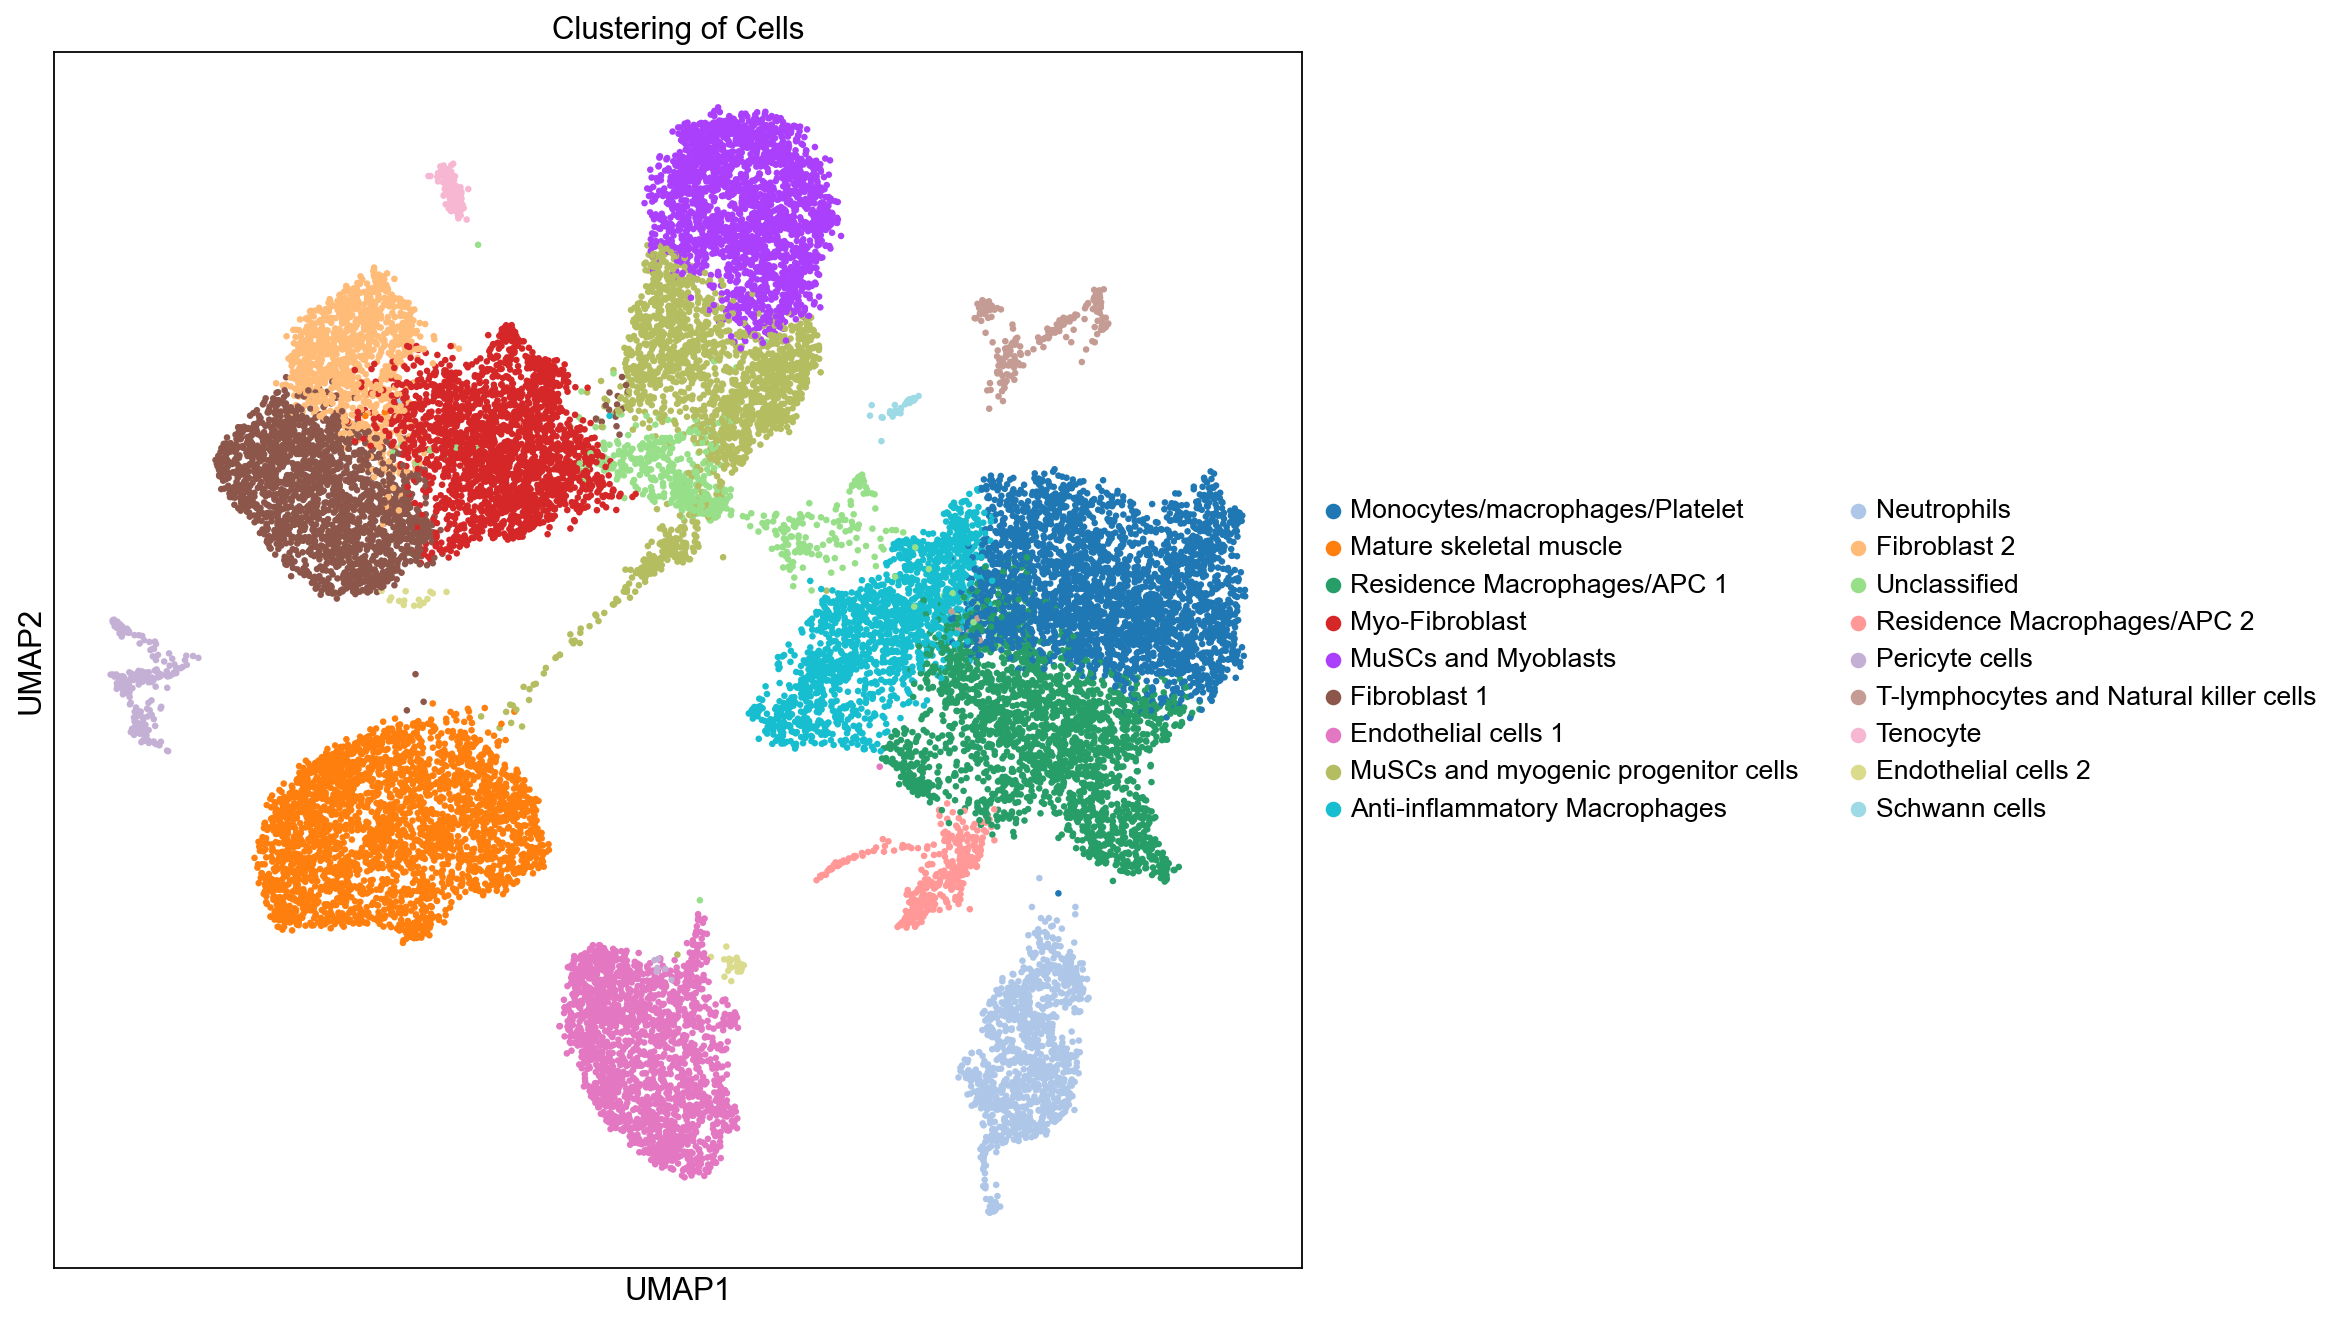

In [27]:
# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['cell type'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=35, title='Clustering of Cells', save=f'umap_plot{img_tag}.png')
pl.show()

In [34]:
from pylab import * 
import matplotlib as mpl

cmap = cm.get_cmap("tab20", 20)

for i in range(cmap.N):
    rgba = cmap(i)
    print(mpl.colors.rgb2hex(rgba))

#1f77b4
#aec7e8
#ff7f0e
#ffbb78
#2ca02c
#98df8a
#d62728
#ff9896
#9467bd
#c5b0d5
#8c564b
#c49c94
#e377c2
#f7b6d2
#7f7f7f
#c7c7c7
#bcbd22
#dbdb8d
#17becf
#9edae5


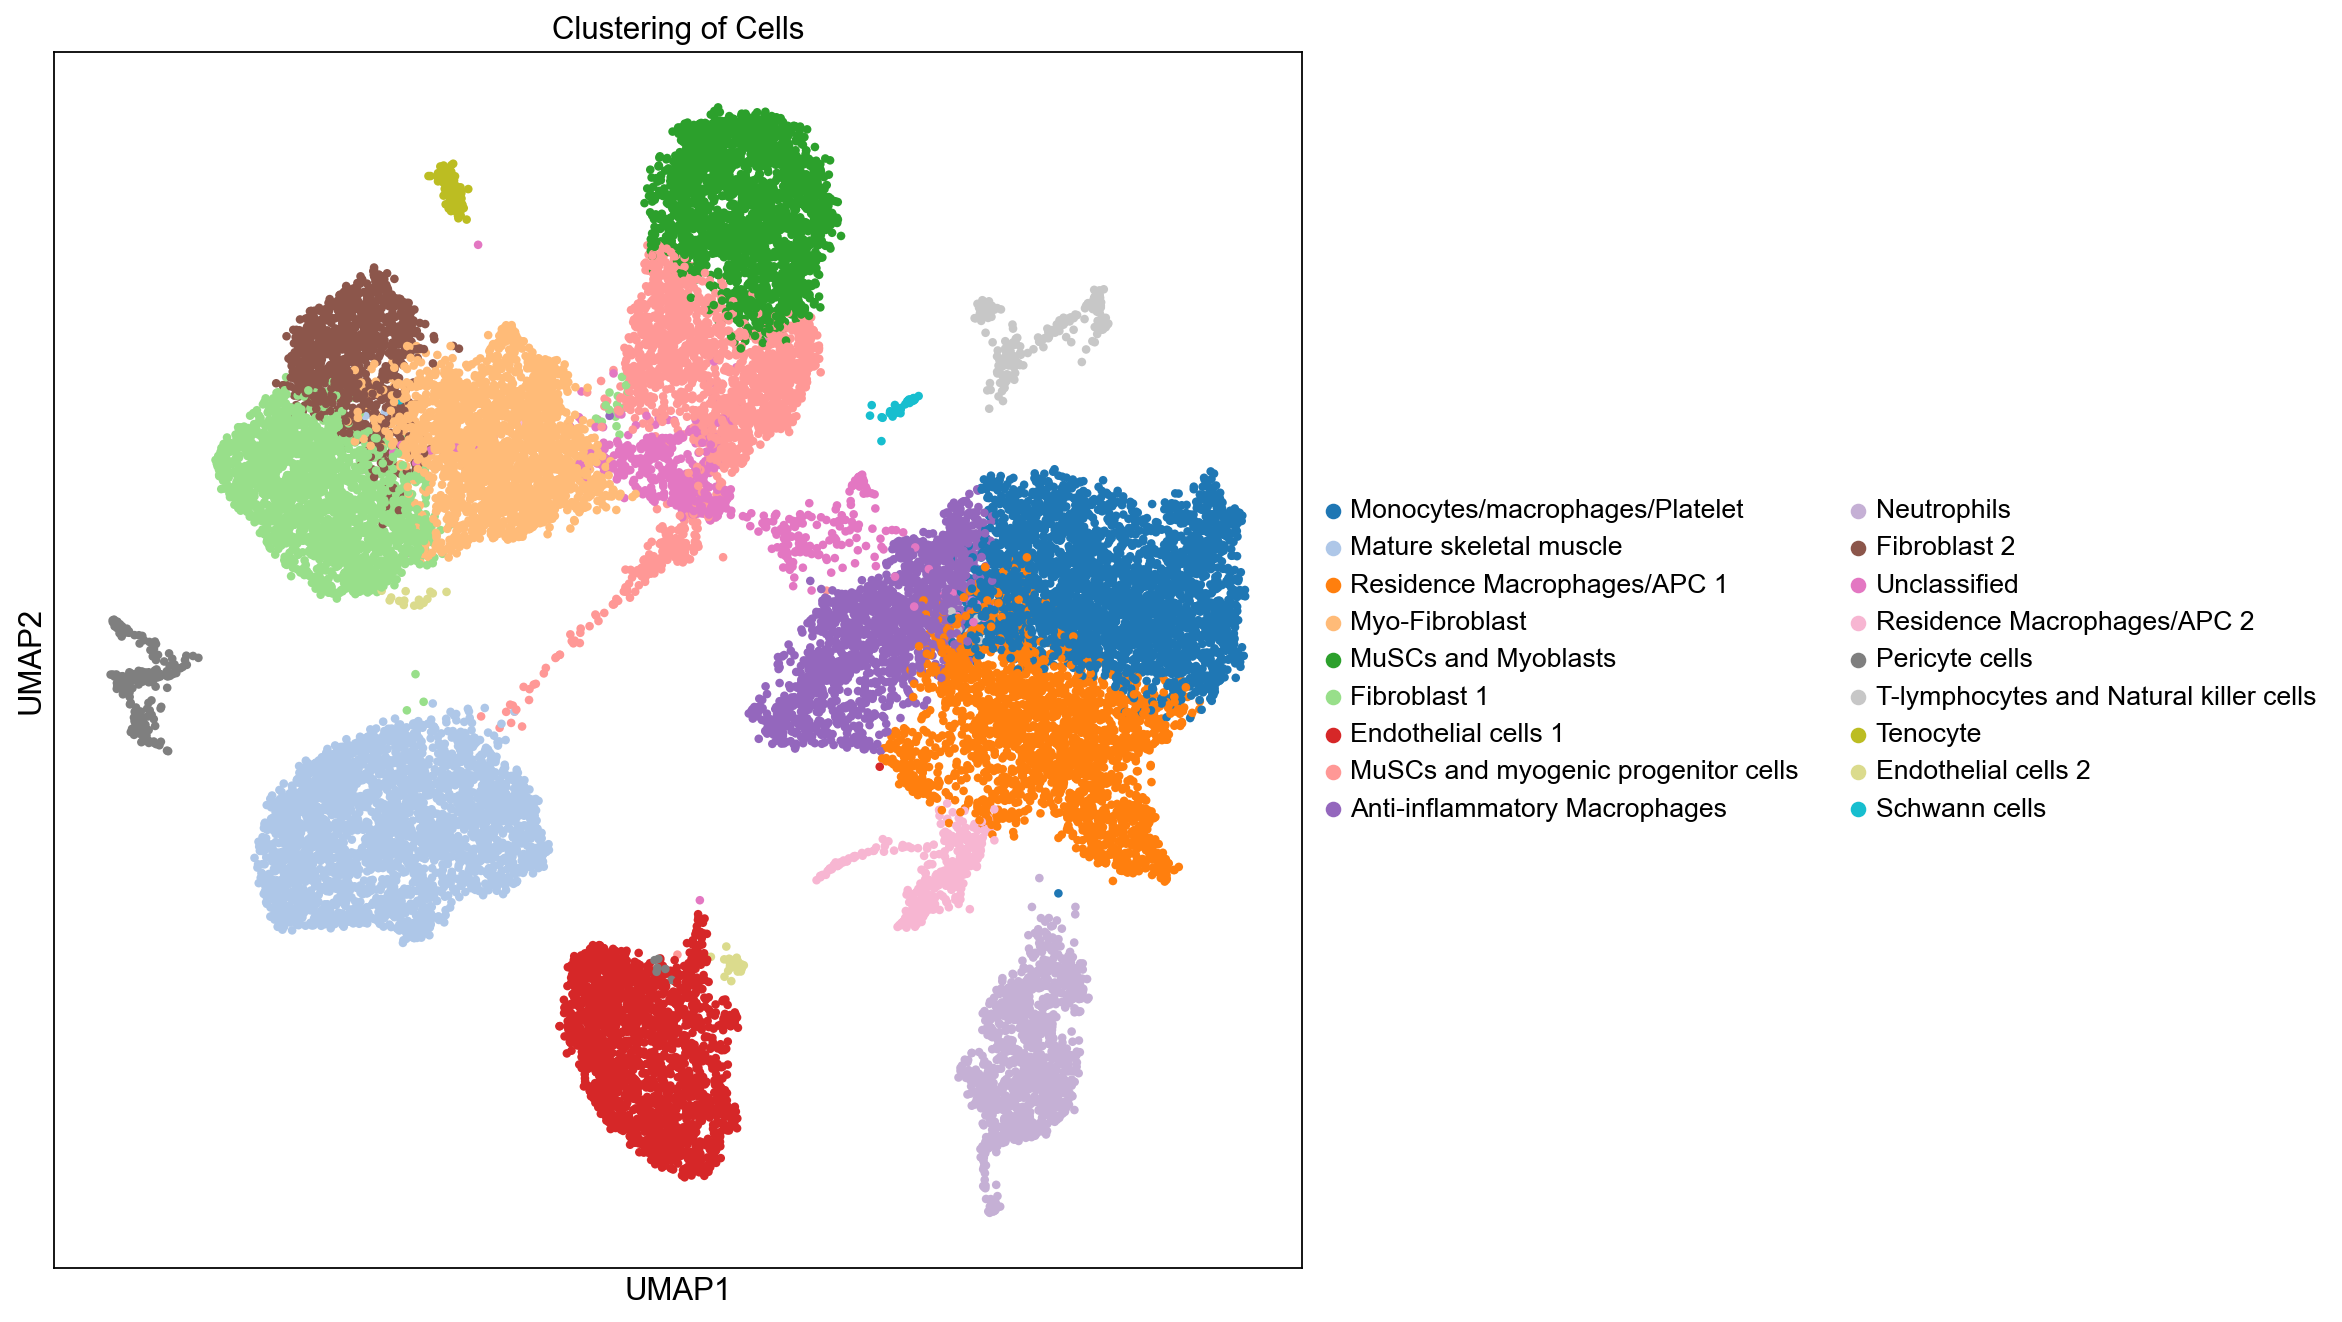

In [35]:
# Set figure parameters
celltypePalette = {
     "Monocytes/macrophages/Platelet": '#1f77b4',
     "Mature skeletal muscle": '#aec7e8',
     "Residence Macrophages/APC 1": '#ff7f0e',
     "Myo-Fibroblast": '#ffbb78',
     "MuSCs and Myoblasts": '#2ca02c',
     "Fibroblast 1": '#98df8a',
     "Endothelial cells 1": '#d62728',
     "MuSCs and myogenic progenitor cells": '#ff9896',
     "Anti-inflammatory Macrophages": '#9467bd',
     "Neutrophils": '#c5b0d5',
     "Fibroblast 2": '#8c564b',
     "Unclassified": '#c49c94',
     "Unclassified": '#e377c2',
     "Residence Macrophages/APC 2": '#f7b6d2',
     "Pericyte cells": '#7f7f7f',
     "T-lymphocytes and Natural killer cells": '#c7c7c7',
     "Tenocyte": '#bcbd22',
     "Endothelial cells 2": '#dbdb8d',
     "Schwann cells": '#17becf',  
}

# Set figure parameters
sc.set_figure_params(figsize=(10, 10))

# Plot UMAP with specified color palette for cell types
sc.pl.umap(adata, color='cell type', palette=celltypePalette, legend_fontsize=12, legend_fontoutline=2, frameon=True, size=60, title='Clustering of Cells', save='umap_plot_color.png')
pl.show()

In [ ]:
#COUNTING CELLS
adata.obs['Sample'].unique().tolist()
def map_condition(x):
    if 'Sham_GFP' in x:
        return 'Sham_GFP'
    elif 'Sham_noGFP' in x:
        return 'Sham_noGFP'
    elif 'OV_GFP' in x:
        return 'OV_GFP'
    else:
        return 'OV_noGFP'

adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs


In [ ]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.n_genes))
num_tot_cells



In [ ]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()

cell_type_counts

In [ ]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.n_genes / cell_type_counts.total_cells

cell_type_counts

<Figure size 960x640 with 0 Axes>

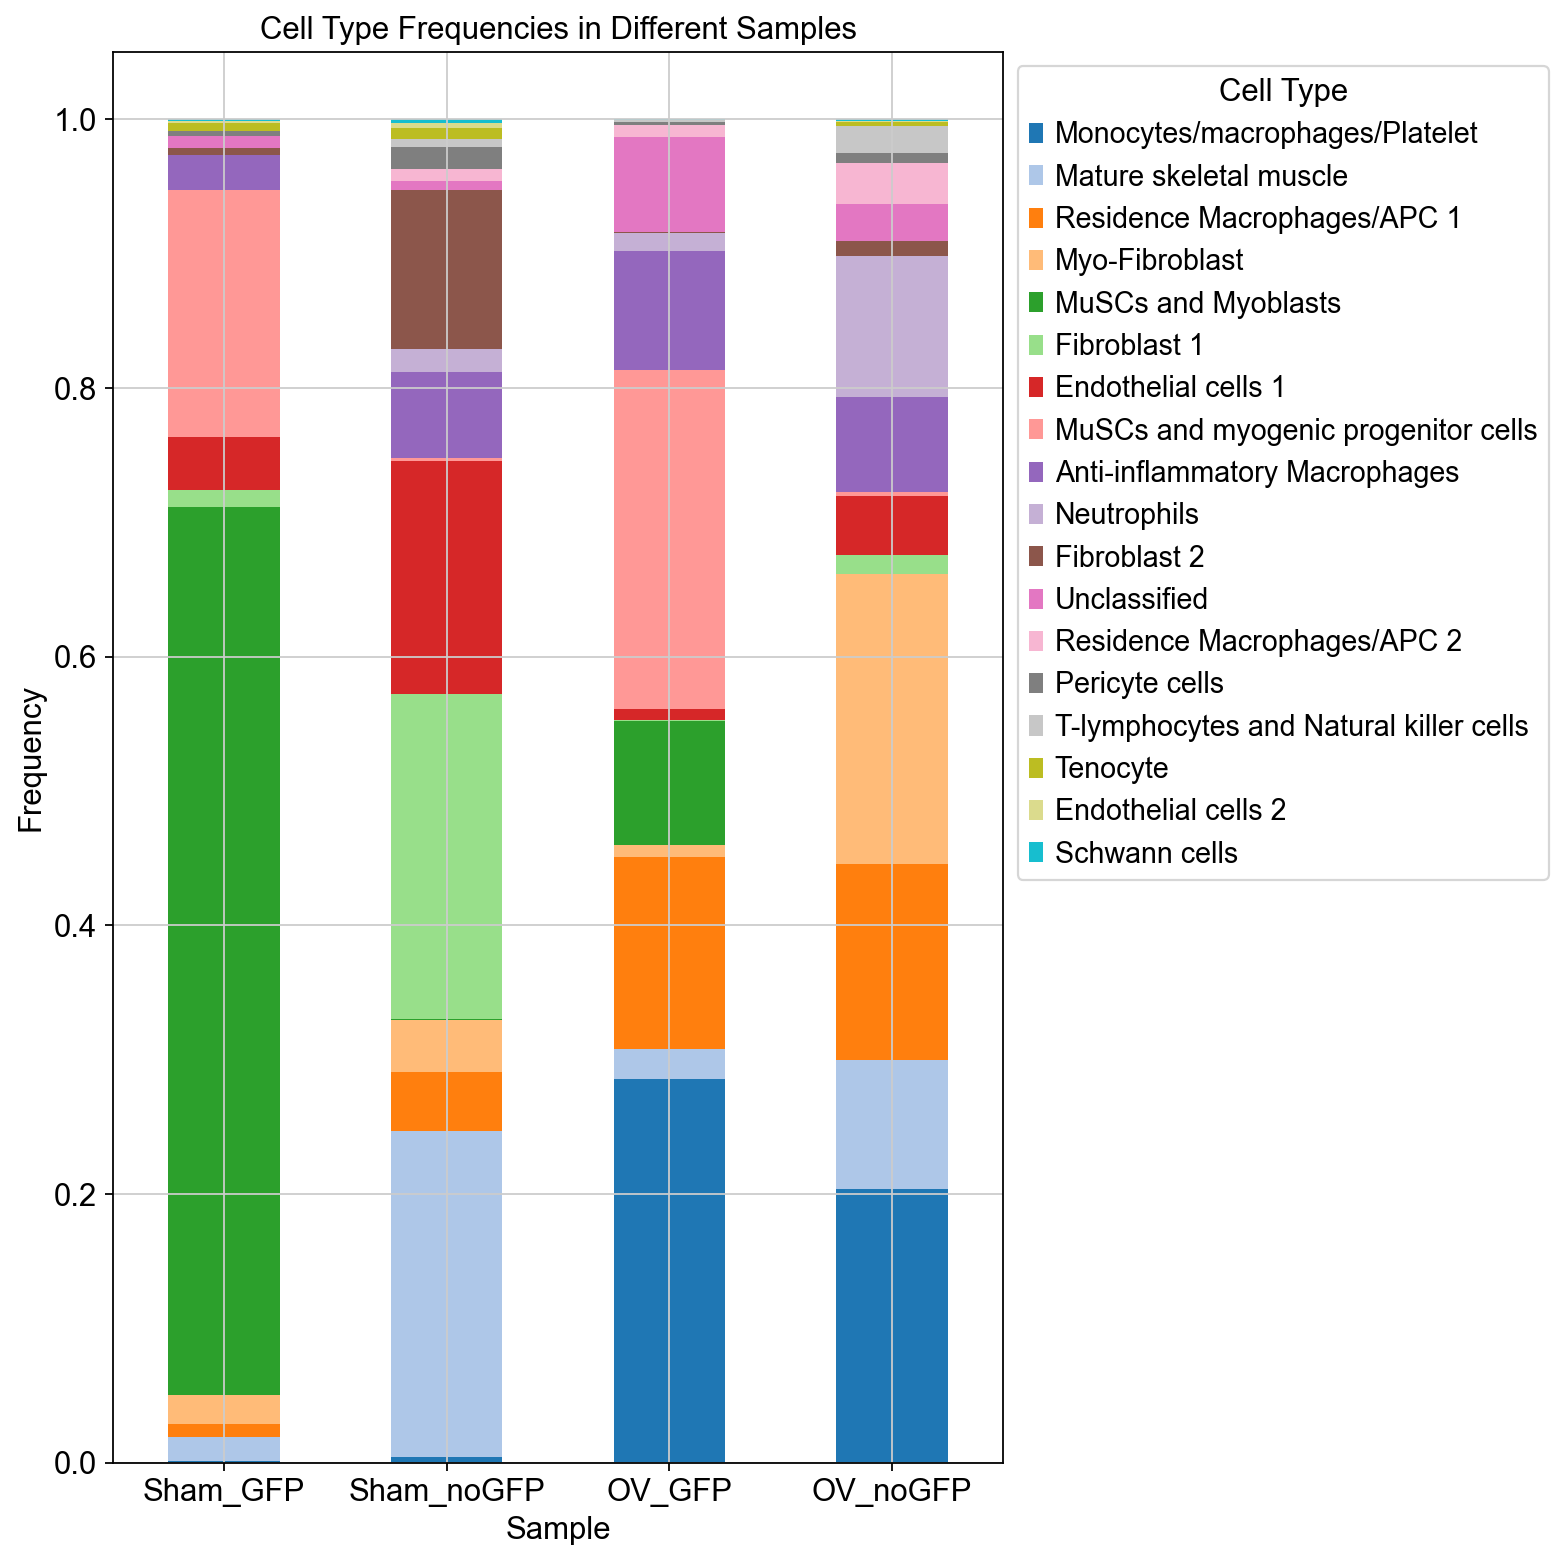

In [36]:
# Your color palette
celltypePalette = {
     "Monocytes/macrophages/Platelet": '#1f77b4',
     "Mature skeletal muscle": '#aec7e8',
     "Residence Macrophages/APC 1": '#ff7f0e',
     "Myo-Fibroblast": '#ffbb78',
     "MuSCs and Myoblasts": '#2ca02c',
     "Fibroblast 1": '#98df8a',
     "Endothelial cells 1": '#d62728',
     "MuSCs and myogenic progenitor cells": '#ff9896',
     "Anti-inflammatory Macrophages": '#9467bd',
     "Neutrophils": '#c5b0d5',
     "Fibroblast 2": '#8c564b',
     "Unclassified": '#c49c94',
     "Unclassified": '#e377c2',
     "Residence Macrophages/APC 2": '#f7b6d2',
     "Pericyte cells": '#7f7f7f',
     "T-lymphocytes and Natural killer cells": '#c7c7c7',
     "Tenocyte": '#bcbd22',
     "Endothelial cells 2": '#dbdb8d',
     "Schwann cells": '#17becf',  
}

# Filter cell_type_counts to include only relevant columns
cell_type_counts = cell_type_counts[['Sample', 'condition', 'cell type', 'frequency']]

# Set the figure size
plt.figure(figsize=(12, 8))

# Define the order of samples in the plot
sample_order = ['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP']

# Filter data for the specified samples
filtered_data = cell_type_counts[cell_type_counts['condition'].isin(sample_order)]

# Pivot the DataFrame for a stacked bar plot
stacked_data = filtered_data.pivot_table(index='condition', columns='cell type', values='frequency', fill_value=0)

# Create a stacked bar plot with the specified color palette
stacked_data.plot(kind='bar', stacked=True, color=[celltypePalette[col] for col in stacked_data.columns])

# Set plot properties
pl.xticks(rotation=0)  # Keep the x-axis labels horizontal
pl.xlabel('Sample')
pl.ylabel('Frequency')
pl.legend(title='Cell Type', bbox_to_anchor=(1, 1))  # Move the legend outside the plot area
pl.title('Cell Type Frequencies in Different Samples')
pl.tight_layout()
pl.savefig('bar4_plot.png')
# Show the plot
pl.show()

In [38]:
# Calculate percentages for each cell type across groups
percentage_data = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100
# Export percentages to a CSV file
percentage_data.to_csv('cell_type_percentages.csv', index=True)


In [24]:
#Merge similar clusters


cell_type = {
    "0": "Immune cells",
    "1": "Mature skeletal muscle",
    "2": "Immune cells",
    "3": "Fibrogenic cells",
    "4": "MuSCs and progenitors",
    "5": "Fibrogenic cells",
    "6": "Endothelial cells",
    "7": "MuSCs and progenitors",
    "8": "Immune cells",
    "9": "Immune cells",
    "10": "Fibrogenic cells",
    "11": "Unclassified",
    "12": "Immune cells",
    "13": "Pericyte cells",
    "14": "Immune cells",
    "15": "Tenocyte",
    "16": "Endothelial cells",
    "17": "Schwann cells",
   
}

In [25]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

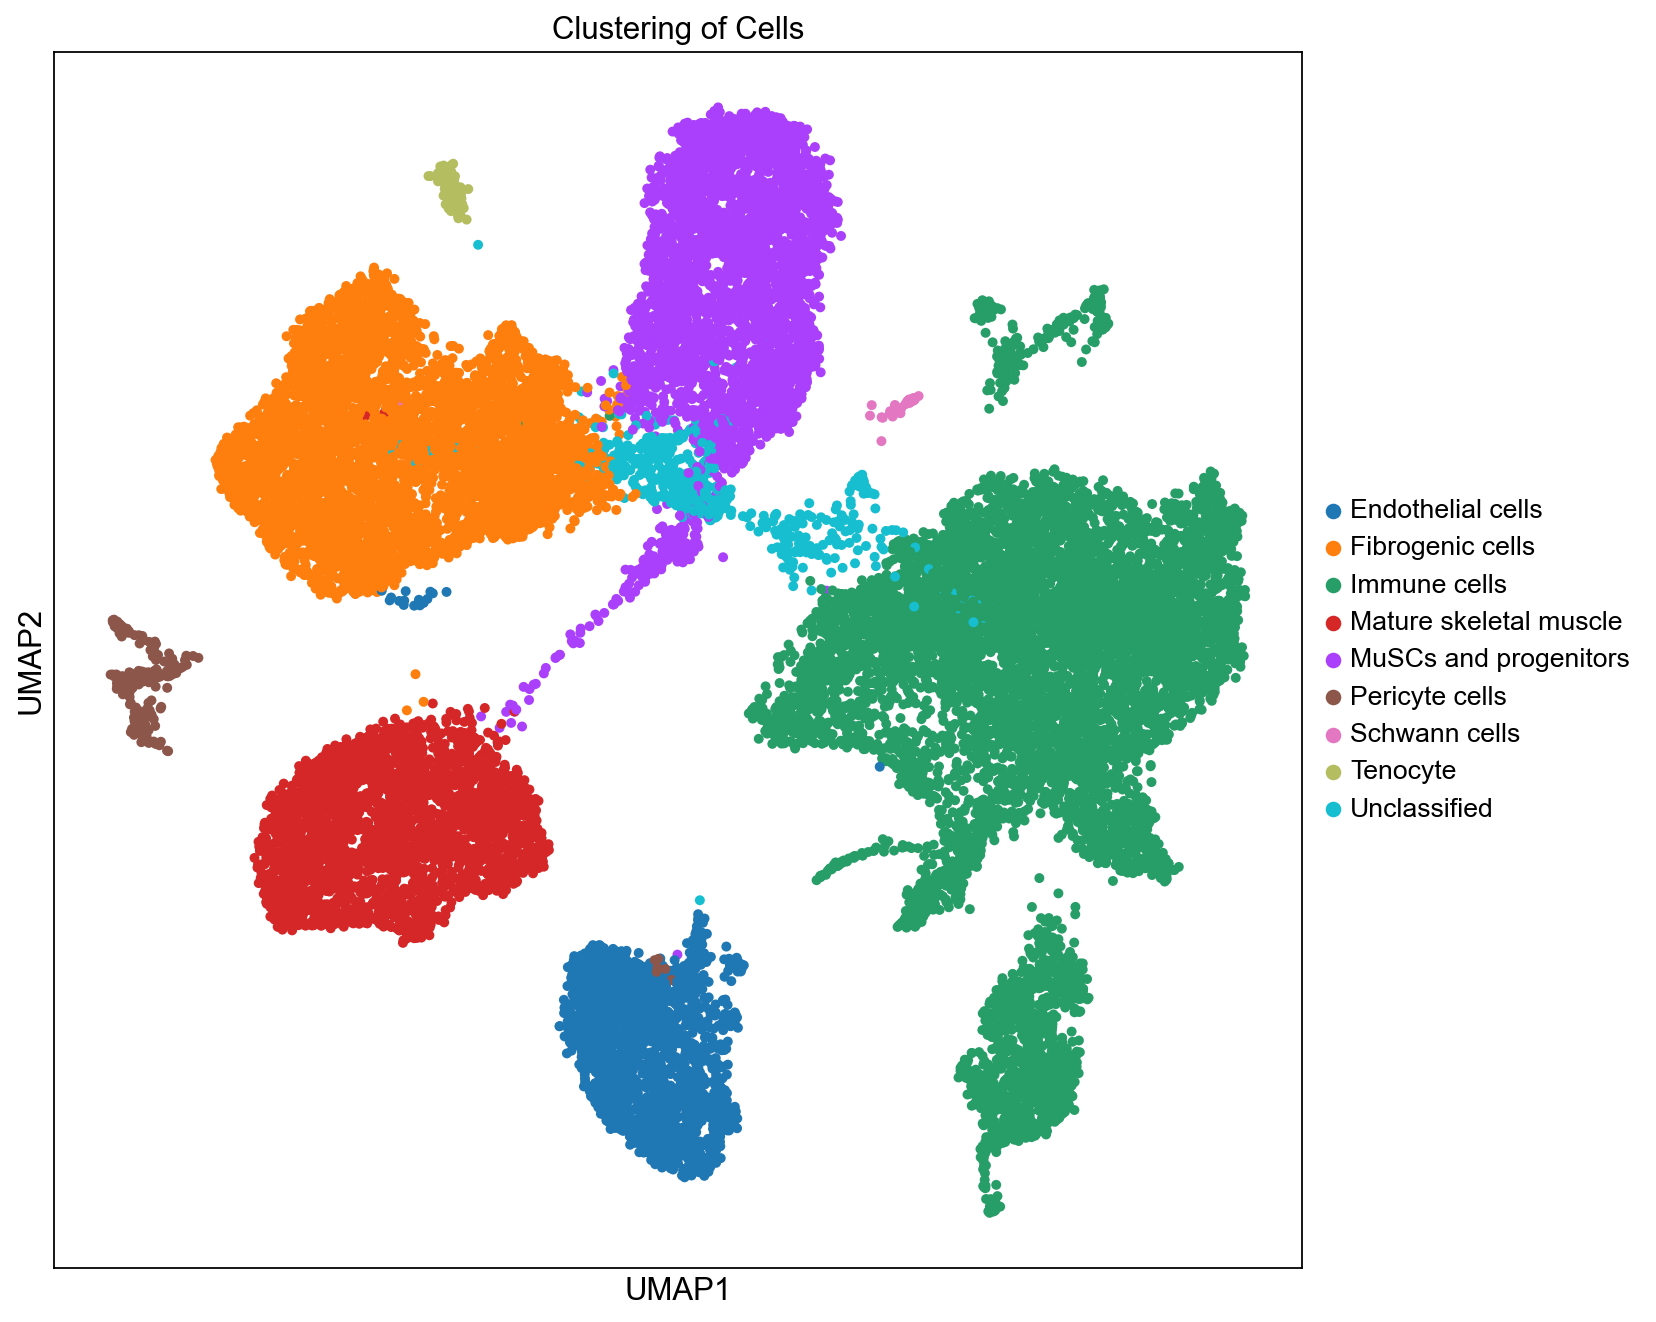

In [41]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['cell type'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=80, title='Clustering of Cells', save=f'umap_plot{img_tag}.png')
pl.show()

In [26]:
from pylab import * 
import matplotlib as mpl

cmap = cm.get_cmap("tab20", 20)

for i in range(cmap.N):
    rgba = cmap(i)
    print(mpl.colors.rgb2hex(rgba))

#1f77b4
#aec7e8
#ff7f0e
#ffbb78
#2ca02c
#98df8a
#d62728
#ff9896
#9467bd
#c5b0d5
#8c564b
#c49c94
#e377c2
#f7b6d2
#7f7f7f
#c7c7c7
#bcbd22
#dbdb8d
#17becf
#9edae5


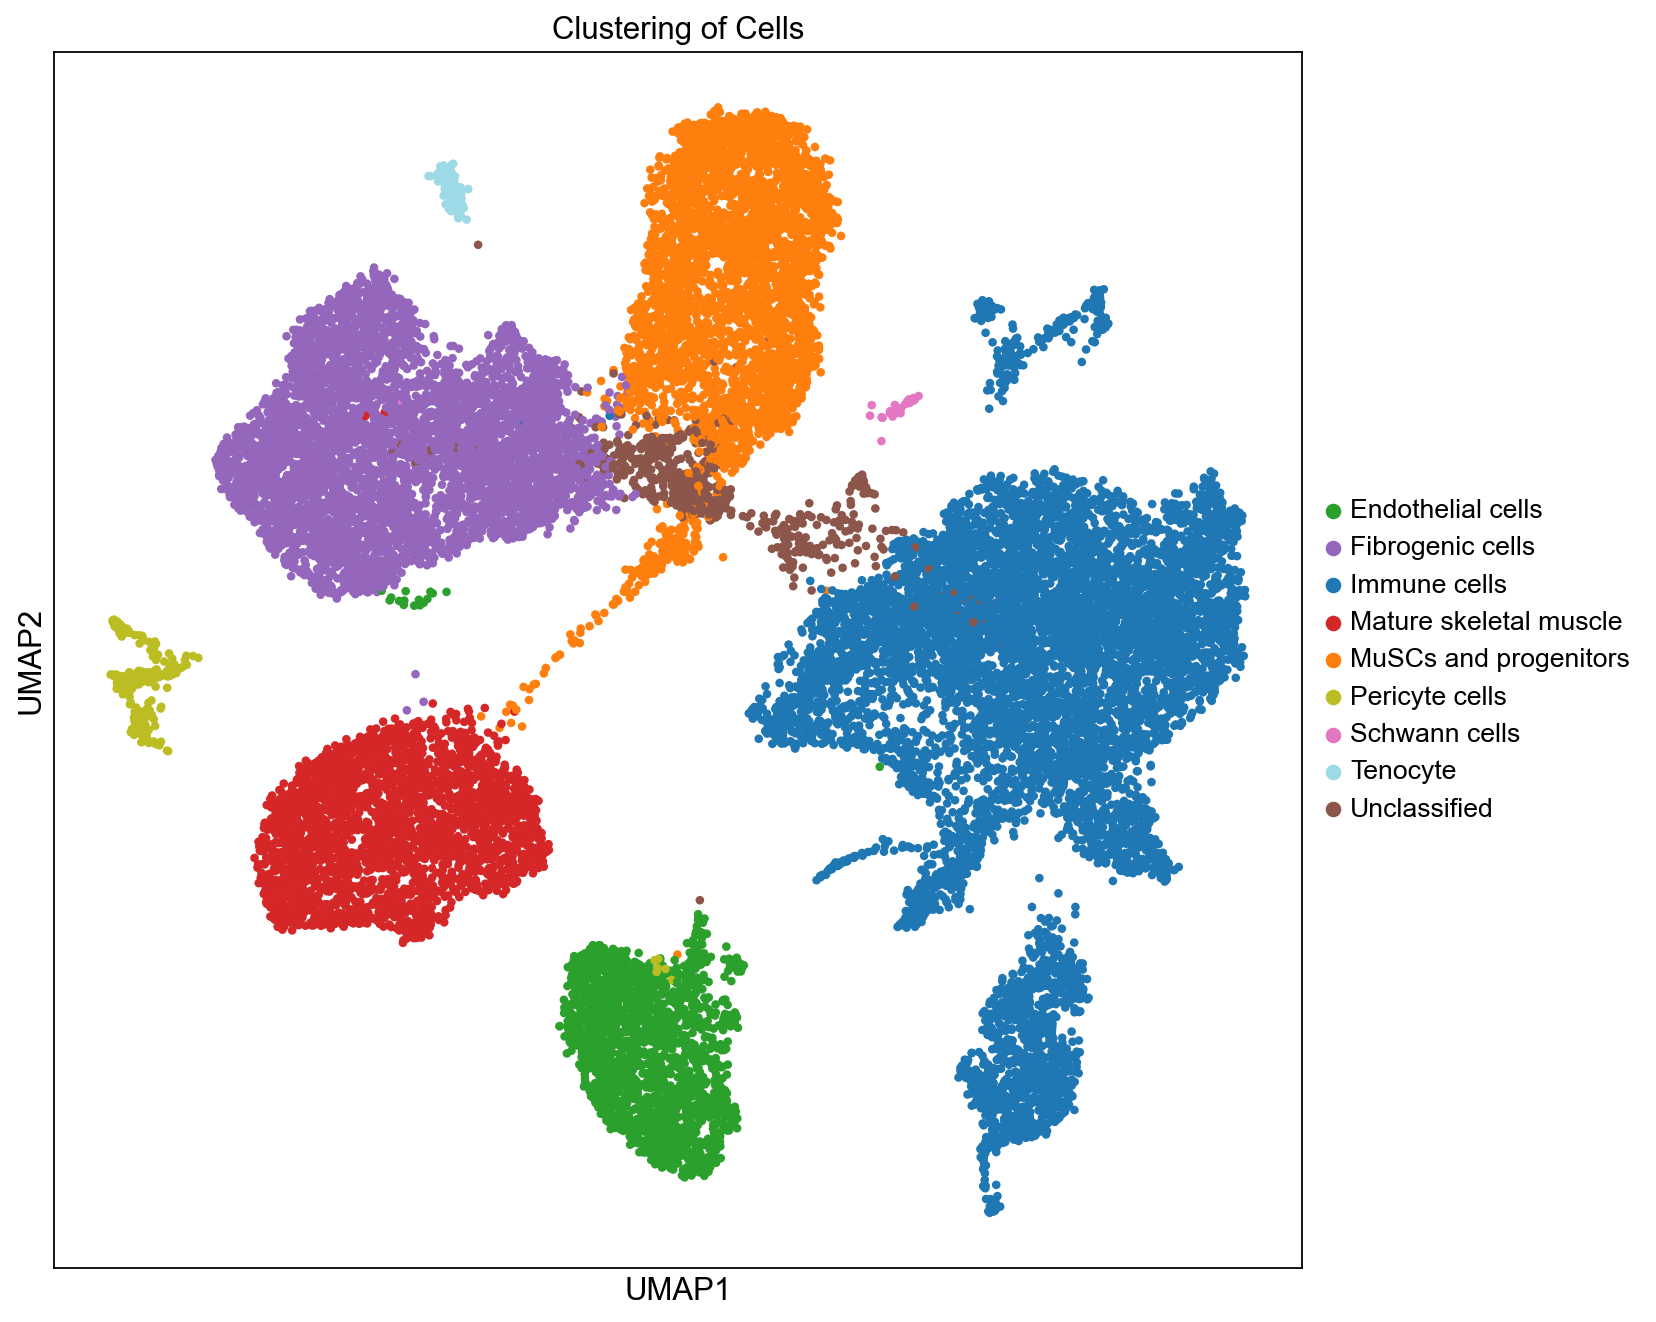

In [49]:
# Set figure parameters


celltypePalette = {
    "Endothelial cells": '#2ca02c',
    "Fibrogenic cells": '#9467bd',
    "Immune cells": '#1f77b4',
    "Mature skeletal muscle": '#d62728',
    "MuSCs and progenitors": '#ff7f0e',
    "Pericyte cells": '#bcbd22',
    "Schwann cells": '#e377c2',
    "Tenocyte": '#9edae5',
    "Unclassified": '#8c564b',
}
# Set figure parameters
sc.set_figure_params(figsize=(10, 10))

# Plot UMAP with specified color palette for cell types
sc.pl.umap(adata, color='cell type', palette=celltypePalette, legend_fontsize=12, legend_fontoutline=2, frameon=True, size=60, title='Clustering of Cells', save='umap_plot_color.png')
pl.show()

In [28]:
adata.write_h5ad('integrated.h5ad')

In [29]:
#COUNTING CELLS


adata.obs['Sample'].unique().tolist()
def map_condition(x):
    if 'Sham_GFP' in x:
        return 'Sham_GFP'
    elif 'Sham_noGFP' in x:
        return 'Sham_noGFP'
    elif 'OV_GFP' in x:
        return 'OV_GFP'
    else:
        return 'OV_noGFP'

adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs


Sample  n_genes  n_genes_by_counts  \
AAACCCAGTTCCGTTC-1-Sham_GFP  Sham_GFP     3572               3572   
AAACCCATCCATACTT-1-Sham_GFP  Sham_GFP     2373               2373   
AAACCCATCCCACAGG-1-Sham_GFP  Sham_GFP     2003               2003   
AAACGAACATACCACA-1-Sham_GFP  Sham_GFP     2215               2215   
AAACGAAGTCGTGGTC-1-Sham_GFP  Sham_GFP     2247               2247   
...                               ...      ...                ...   
TTTGTTGAGATGGCGT-1-OV_noGFP  OV_noGFP     1633               1633   
TTTGTTGCACCGAATT-1-OV_noGFP  OV_noGFP     4213               4213   
TTTGTTGCATCCTTCG-1-OV_noGFP  OV_noGFP     2729               2729   
TTTGTTGGTCAGGAGT-1-OV_noGFP  OV_noGFP     1561               1561   
TTTGTTGGTTGTGCAT-1-OV_noGFP  OV_noGFP     2638               2638   

                             total_counts  total_counts_mt  pct_counts_mt  \
AAACCCAGTTCCGTTC-1-Sham_GFP       11059.0            432.0       3.906321   
AAACCCATCCATACTT-1-Sham_GFP        7142.0            280.0       3.920470   
AAACCCATCCCACAGG-1-Sham_GFP        5501.0            139.0       2.526813   
AAACGAACATACCACA-1-Sham_GFP        6809.0            175.0       2.570128   
AAACGAAGTCGTGGTC-1-Sham_GFP        6941.0            388.0       5.589973   
...                                   ...              ...            ...   
TTTGTTGAGATGGCGT-1-OV_noGFP        3283.0            175.0       5.330490   
TTTGTTGCACCGAATT-1-OV_noGFP       19380.0            352.0       1.816306   
TTTGTTGCATCCTTCG-1-OV_noGFP        8288.0            163.0       1.966699   
TTTGTTGGTCAGGAGT-1-OV_noGFP        3544.0             58.0       1.636569   
TTTGTTGGTTGTGCAT-1-OV_noGFP        7337.0            355.0       4.838490   

                            leiden                       cell type condition  
AAACCCAGTTCCGTTC-1-Sham_GFP      6             Endothelial cells 1  Sham_GFP  
AAACCCATCCATACTT-1-Sham_GFP      4             MuSCs and Myoblasts  Sham_GFP  
AAACCCATCCCACAGG-1-Sham_GFP      4             MuSCs and Myoblasts  Sham_GFP  
AAACGAACATACCACA-1-Sham_GFP      4             MuSCs and Myoblasts  Sham_GFP  
AAACGAAGTCGTGGTC-1-Sham_GFP      4             MuSCs and Myoblasts  Sham_GFP  
...                            ...                             ...       ...  
TTTGTTGAGATGGCGT-1-OV_noGFP      0  Monocytes/macrophages/Platelet  OV_noGFP  
TTTGTTGCACCGAATT-1-OV_noGFP      8   Anti-inflammatory Macrophages  OV_noGFP  
TTTGTTGCATCCTTCG-1-OV_noGFP      0  Monocytes/macrophages/Platelet  OV_noGFP  
TTTGTTGGTCAGGAGT-1-OV_noGFP      2     Residence Macrophages/APC 1  OV_noGFP  
TTTGTTGGTTGTGCAT-1-OV_noGFP      0  Monocytes/macrophages/Platelet  OV_noGFP  

[23528 rows x 9 columns]

In [30]:
adata.write_h5ad('integrated2.h5ad')

In [31]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.n_genes))
num_tot_cells

{'Sham_GFP': 2659, 'Sham_noGFP': 7950, 'OV_GFP': 4593, 'OV_noGFP': 8326}

In [32]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()

cell_type_counts

Sample condition                               cell type  n_genes  \
0   Sham_GFP  Sham_GFP          Monocytes/macrophages/Platelet        3   
1   Sham_GFP  Sham_GFP                  Mature skeletal muscle       48   
2   Sham_GFP  Sham_GFP             Residence Macrophages/APC 1       26   
3   Sham_GFP  Sham_GFP                          Myo-Fibroblast       56   
4   Sham_GFP  Sham_GFP                     MuSCs and Myoblasts     1758   
..       ...       ...                                     ...      ...   
63  OV_noGFP  OV_noGFP                          Pericyte cells       66   
64  OV_noGFP  OV_noGFP  T-lymphocytes and Natural killer cells      165   
65  OV_noGFP  OV_noGFP                                Tenocyte       24   
66  OV_noGFP  OV_noGFP                     Endothelial cells 2        8   
67  OV_noGFP  OV_noGFP                           Schwann cells       11   

    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  leiden  
0                   3             3                3              3       3  
1                  48            48               48             48      48  
2                  26            26               26             26      26  
3                  56            56               56             56      56  
4                1758          1758             1758           1758    1758  
..                ...           ...              ...            ...     ...  
63                 66            66               66             66      66  
64                165           165              165            165     165  
65                 24            24               24             24      24  
66                  8             8                8              8       8  
67                 11            11               11             11      11  

[68 rows x 9 columns]

In [33]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.n_genes / cell_type_counts.total_cells

cell_type_counts

Sample condition                               cell type  n_genes  \
0   Sham_GFP  Sham_GFP          Monocytes/macrophages/Platelet        3   
1   Sham_GFP  Sham_GFP                  Mature skeletal muscle       48   
2   Sham_GFP  Sham_GFP             Residence Macrophages/APC 1       26   
3   Sham_GFP  Sham_GFP                          Myo-Fibroblast       56   
4   Sham_GFP  Sham_GFP                     MuSCs and Myoblasts     1758   
..       ...       ...                                     ...      ...   
63  OV_noGFP  OV_noGFP                          Pericyte cells       66   
64  OV_noGFP  OV_noGFP  T-lymphocytes and Natural killer cells      165   
65  OV_noGFP  OV_noGFP                                Tenocyte       24   
66  OV_noGFP  OV_noGFP                     Endothelial cells 2        8   
67  OV_noGFP  OV_noGFP                           Schwann cells       11   

    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  leiden  \
0                   3             3                3              3       3   
1                  48            48               48             48      48   
2                  26            26               26             26      26   
3                  56            56               56             56      56   
4                1758          1758             1758           1758    1758   
..                ...           ...              ...            ...     ...   
63                 66            66               66             66      66   
64                165           165              165            165     165   
65                 24            24               24             24      24   
66                  8             8                8              8       8   
67                 11            11               11             11      11   

    total_cells  frequency  
0          2659   0.001128  
1          2659   0.018052  
2          2659   0.009778  
3          2659   0.021061  
4          2659   0.661151  
..          ...        ...  
63         8326   0.007927  
64         8326   0.019817  
65         8326   0.002883  
66         8326   0.000961  
67         8326   0.001321  

[68 rows x 11 columns]

<Figure size 960x640 with 0 Axes>

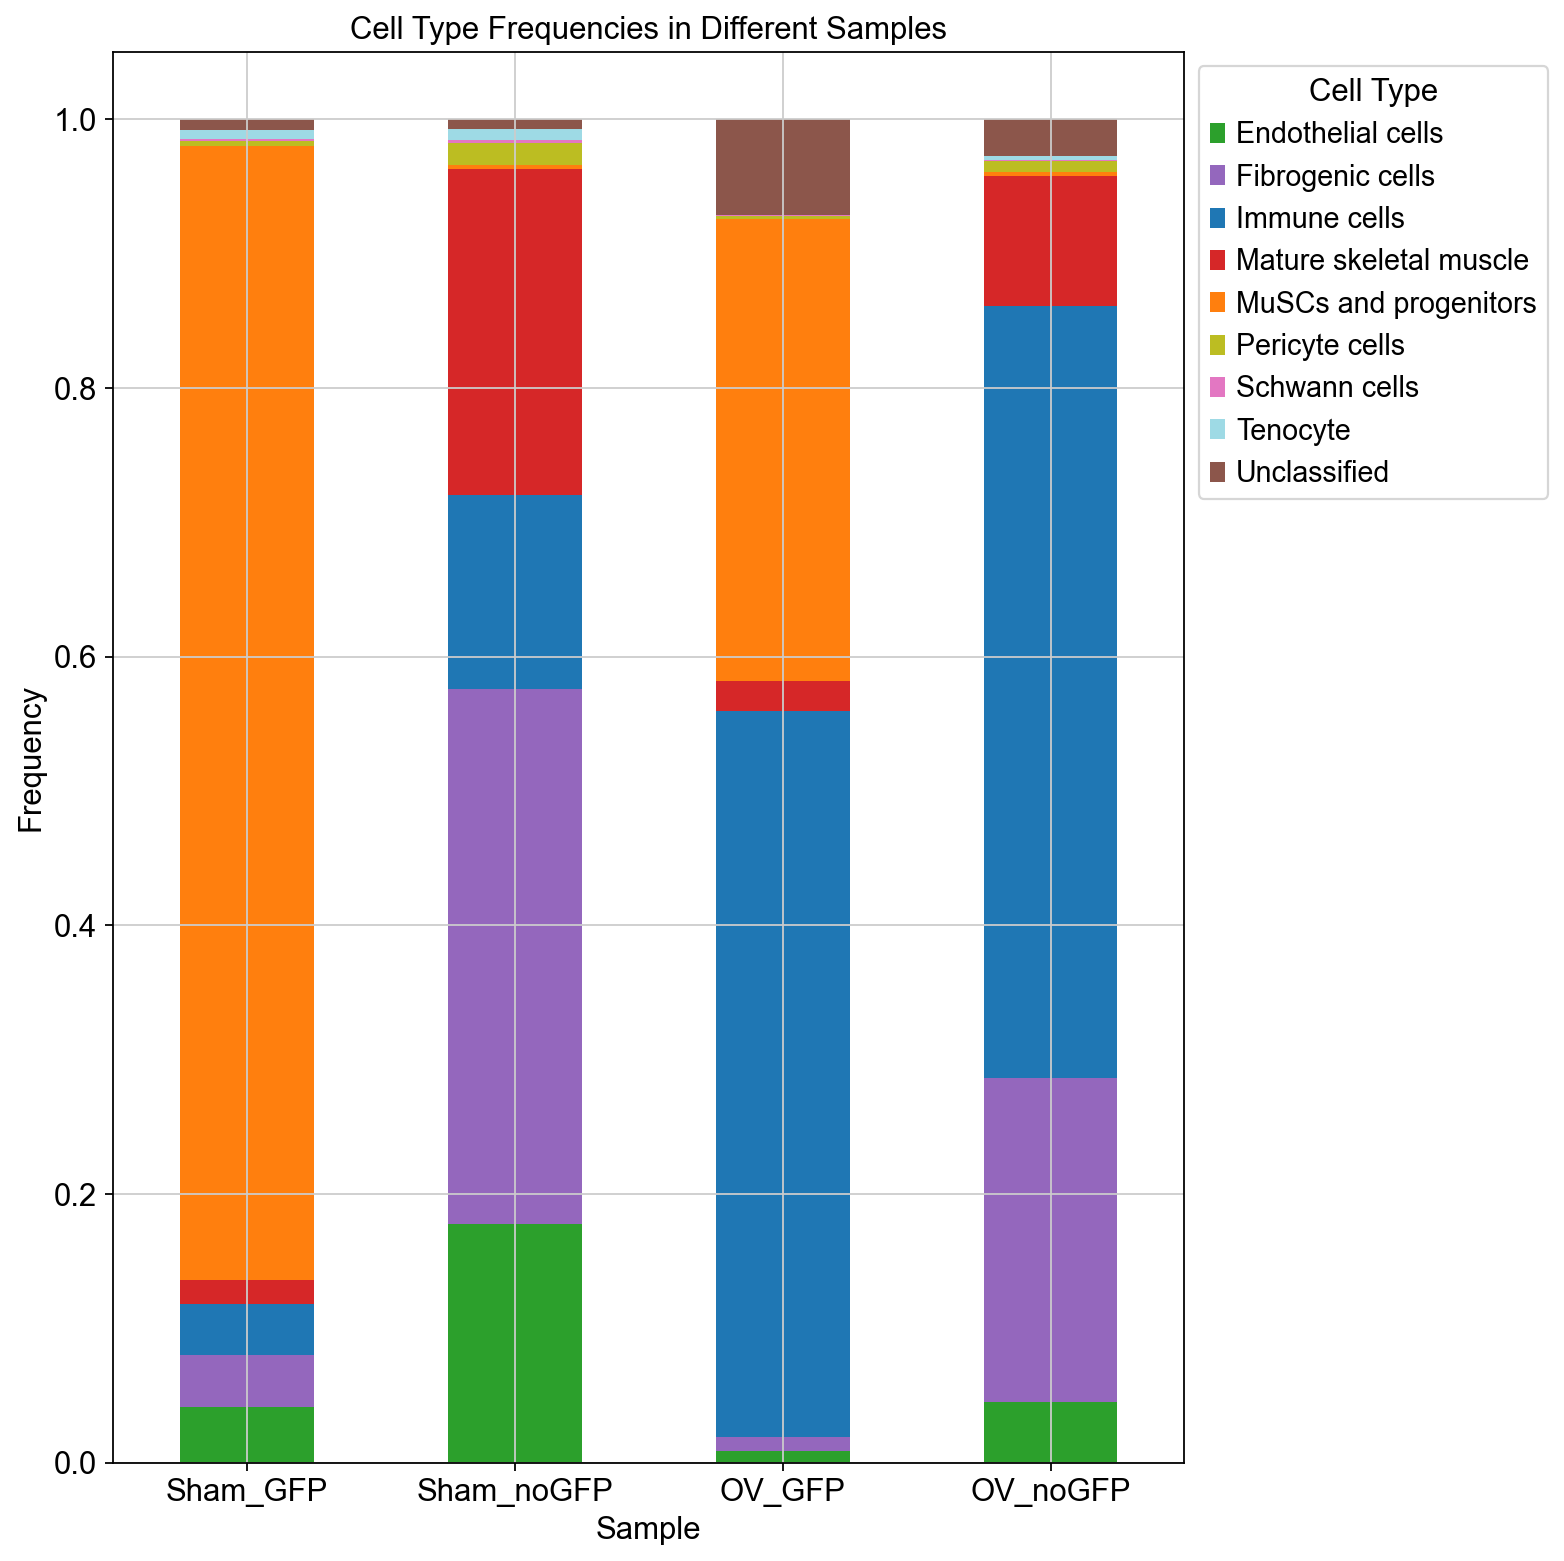

In [60]:
# Your color palette
celltypePalette = {
    "Endothelial cells": '#2ca02c',
    "Fibrogenic cells": '#9467bd',
    "Immune cells": '#1f77b4',
    "Mature skeletal muscle": '#d62728',
    "MuSCs and progenitors": '#ff7f0e',
    "Pericyte cells": '#bcbd22',
    "Schwann cells": '#e377c2',
    "Tenocyte": '#9edae5',
    "Unclassified": '#8c564b',
}

# Filter cell_type_counts to include only relevant columns
cell_type_counts = cell_type_counts[['Sample', 'condition', 'cell type', 'frequency']]

# Set the figure size
plt.figure(figsize=(12, 8))

# Define the order of samples in the plot
sample_order = ['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP']

# Filter data for the specified samples
filtered_data = cell_type_counts[cell_type_counts['condition'].isin(sample_order)]

# Pivot the DataFrame for a stacked bar plot
stacked_data = filtered_data.pivot_table(index='condition', columns='cell type', values='frequency', fill_value=0)

# Create a stacked bar plot with the specified color palette
stacked_data.plot(kind='bar', stacked=True, color=[celltypePalette[col] for col in stacked_data.columns])

# Set plot properties
pl.xticks(rotation=0)  # Keep the x-axis labels horizontal
pl.xlabel('Sample')
pl.ylabel('Frequency')
pl.legend(title='Cell Type', bbox_to_anchor=(1, 1))  # Move the legend outside the plot area
pl.title('Cell Type Frequencies in Different Samples')
pl.tight_layout()
pl.savefig('bar4_plot.png')
# Show the plot
pl.show()

In [61]:
# Calculate percentages for each cell type across groups
percentage_data = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100
# Export percentages to a CSV file
percentage_data.to_csv('cell_type_percentagescompress.csv', index=True)
